# Importing libraries

In [1]:
#pip install plotly==5.0.0
#pip install xgboost
#pip install category-encoders
#pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import statistics
import time

#Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

import plotly.express as px

In [3]:
# Import packages for statistical testing
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# Import packages for model building
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor

In [5]:
import imblearn
#print(imblearn.__version__)

In [6]:
# Import packages for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score

In [7]:
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Data preprocessing

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
campaign = pd.read_csv('campaign_data.csv')
coupon = pd.read_csv('coupon_item_mapping.csv')
demog = pd.read_csv('customer_demographics.csv')
transaction = pd.read_csv('customer_transaction_data.csv')
item = pd.read_csv('item_data.csv')

#To update data and save them easily, a dictionary is created. 
tables ={}
tables['train'] = train
tables['campaign'] = campaign
tables['coupon'] = coupon 
tables['demog'] = demog
tables['transaction'] = transaction 
tables['item'] = item

## Train table

In [9]:
train.head()

id  campaign_id  coupon_id  customer_id  redemption_status
0   1           13         27         1053                  0
1   2           13        116           48                  0
2   6            9        635          205                  0
3   7           13        644         1050                  0
4   9            8       1017         1489                  0

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 78369 non-null  int64
 1   campaign_id        78369 non-null  int64
 2   coupon_id          78369 non-null  int64
 3   customer_id        78369 non-null  int64
 4   redemption_status  78369 non-null  int64
dtypes: int64(5)
memory usage: 3.0 MB


In [11]:
train.duplicated().sum()

0

In [12]:
train[['coupon_id', 'customer_id']].duplicated().sum()

1268

In [13]:
train.nunique()

id                   78369
campaign_id             18
coupon_id              866
customer_id           1428
redemption_status        2
dtype: int64

In [14]:
train.redemption_status.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [15]:
print('Overall redemption rate is: {:.2f}%'.format(len(train[train.redemption_status==1].index)/len(train)*100))

Overall redemption rate is: 0.93%


1. Train table has no duplicate, which means each combination of customer_id, coupon_id, and campaign_id is unique. However, not all customer_id+coupon_id combinations are unique (1268 duplicates), which means, the same coupon was used in more than one campaign.
2. Train table contains data from 18 campaigns and involves 866 unique coupons and 1428 unique customers.
3. The data is very imbalanced. Positive rate is only 0.93%.

## Campaign table

In [16]:
campaign.head()

campaign_id campaign_type start_date  end_date
0           24             Y   21/10/13  20/12/13
1           25             Y   21/10/13  22/11/13
2           20             Y   07/09/13  16/11/13
3           23             Y   08/10/13  15/11/13
4           21             Y   16/09/13  18/10/13

In [17]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [18]:
campaign.nunique()

campaign_id      28
campaign_type     2
start_date       25
end_date         26
dtype: int64

In [19]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

In [20]:
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format='%d/%m/%y') #better to specify format
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format='%d/%m/%y')

In [21]:
campaign["campaign_duration"] = (campaign['end_date']-campaign['start_date']).dt.days 
campaign.head()

campaign_id campaign_type start_date   end_date  campaign_duration
0           24             Y 2013-10-21 2013-12-20                 60
1           25             Y 2013-10-21 2013-11-22                 32
2           20             Y 2013-09-07 2013-11-16                 70
3           23             Y 2013-10-08 2013-11-15                 38
4           21             Y 2013-09-16 2013-10-18                 32

In [22]:
campaign_chart = campaign[['campaign_id', 'start_date', 'end_date']]
campaign_chart['campaign'] = ["{} {}".format("Campaign",i) for i in campaign_chart['campaign_id']]
campaign_chart=campaign_chart.sort_values('campaign_id')

transaction['date'] = pd.to_datetime(transaction['date'], format='%Y-%m-%d') #better to specify format
trans_timeline = {'campaign_id':100, 'start_date':transaction['date'].min(), 
          'end_date':transaction['date'].max(),'campaign':'transaction period' }

campaign_chart = campaign_chart.append(trans_timeline,ignore_index=True)
fig = px.timeline(campaign_chart, x_start="start_date", x_end="end_date", y="campaign",
                 width=1000, height=600)
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [23]:
sorted(train.campaign_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30]

1. A total number of 28 campaigns have been conducted from September of 2012 to December of 2013.
2. 22 out of 28 campaigns are type Y; the rest are type X.
3. All campaigns overlap with at least one other campaign. There were no campaign 14 and 15. It is likely that these campaigns were conducted but the data was not made available. (Reason: if we look at the Ganchatt, there is no "break" except for July/August of 2013, which conincides with missing campaign 14 and 15.) Also, the earliest five campaigns have an id from 26-30. Otherwise, the campaign_id is consistent with the order of the campaigns based on start date.
4. Note: Train table contains campaigns 1-13 & 26-30, which occurred during 2012/8/12-2013/7/5. This period of time has no overlap with the campaigns in the test table, thus no data leakage issue!
- One thing we may be able to do to solve two issues (lack of test dataset labels and transaction data leakage) is to use data from campaigns 26-30 & 1-8 (2012/8/12-2013/4/5) to predict results for campaigns 10-13 (2013/4/8-2013/7/5)

In [24]:
# Positive labels for campaigns 26-30 & 1-8
potential_train_campaigns = [1, 2, 3, 4, 5, 6, 7, 8, 26, 27, 28, 29, 30]
train[train.campaign_id.map(
    lambda x: True if x in potential_train_campaigns else False)].redemption_status.value_counts()

0    45205
1      335
Name: redemption_status, dtype: int64

In [25]:
# Positive labels for campaigns 10-13
potential_test_campaigns = [10, 11, 12, 13]
train[train.campaign_id.map(
    lambda x: True if x in potential_test_campaigns else False)].redemption_status.value_counts()

0    29290
1      371
Name: redemption_status, dtype: int64

## Coupon table

In [26]:
coupon.head()

coupon_id  item_id
0        105       37
1        107       75
2        494       76
3        522       77
4        518       77

In [27]:
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


1. How many types of coupon are in the design?
2. How many items does each coupon cover?
3. How frequent does each item show up in a coupon?

In [28]:
coupon.coupon_id.nunique()

1116

In [29]:
num_it_in_cp_df = \
    coupon.groupby('coupon_id')['item_id'].nunique().reset_index().rename(columns={'item_id':'num_it_in_cp'})
#reset_index() converts series to dataframe

In [30]:
num_it_in_cp_df.num_it_in_cp.value_counts()

4       74
3       72
2       67
1       64
5       59
        ..
91       1
92       1
93       1
101      1
3718     1
Name: num_it_in_cp, Length: 118, dtype: int64

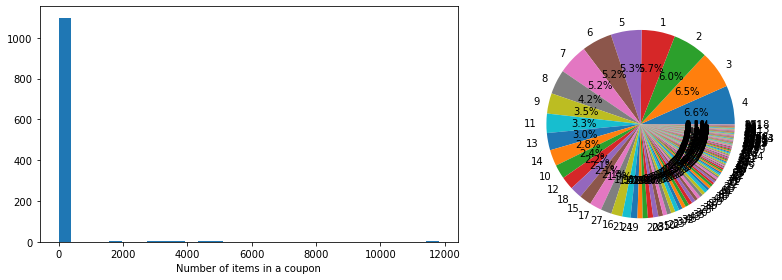

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(num_it_in_cp_df.num_it_in_cp, bins=30)
axes[0].set_xlabel('Number of items in a coupon')
axes[1].pie(num_it_in_cp_df.num_it_in_cp.value_counts(), 
            labels=num_it_in_cp_df.num_it_in_cp.value_counts().index, 
            autopct='%1.1f%%')
fig.tight_layout()

In [32]:
num_it_in_cp_df['num_it_in_cp_bin'] = pd.cut(x=num_it_in_cp_df['num_it_in_cp'], 
                                             bins=[0, 5, 10, 50, 100, 1000, 12000])
print(num_it_in_cp_df['num_it_in_cp_bin'].unique())
num_it_in_cp_df['num_it_in_cp_bin'].value_counts()

[(10, 50], (0, 5], (5, 10], (1000, 12000], (100, 1000], (50, 100]]
Categories (6, interval[int64]): [(0, 5] < (5, 10] < (10, 50] < (50, 100] < (100, 1000] < (1000, 12000]]


(10, 50]         433
(0, 5]           336
(5, 10]          229
(50, 100]         79
(100, 1000]       22
(1000, 12000]     17
Name: num_it_in_cp_bin, dtype: int64

In [33]:
coupon = pd.merge(coupon, num_it_in_cp_df, on='coupon_id', how='left') 
coupon.head()

coupon_id  item_id  num_it_in_cp num_it_in_cp_bin
0        105       37            17         (10, 50]
1        107       75            38         (10, 50]
2        494       76            35         (10, 50]
3        522       77            91        (50, 100]
4        518       77            70        (50, 100]

Flag: 'num_it_in_cp_bin' may need to be optimized

In [34]:
freq_it_in_cp_df = \
    coupon.groupby('item_id')['coupon_id'].nunique().reset_index().\
    rename(columns={'coupon_id':'freq_it_in_cp'})

freq_it_in_cp_df.freq_it_in_cp.value_counts()

3     12943
2     12936
1      5707
4      2807
5      1171
7       321
6       234
8        67
10       56
9        46
11        1
Name: freq_it_in_cp, dtype: int64

Text(0, 0.5, 'Count')

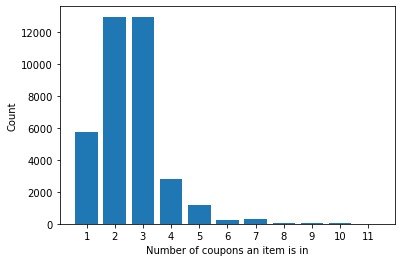

In [35]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.bar(freq_it_in_cp_df.freq_it_in_cp.value_counts().index,
         freq_it_in_cp_df.freq_it_in_cp.value_counts())

axes.set_xticks(freq_it_in_cp_df.freq_it_in_cp.value_counts().index)
axes.set_xlabel('Number of coupons an item is in')
axes.set_ylabel('Count')

In [36]:
coupon = pd.merge(coupon, freq_it_in_cp_df, on='item_id', how='left') 
coupon.head()

coupon_id  item_id  num_it_in_cp num_it_in_cp_bin  freq_it_in_cp
0        105       37            17         (10, 50]              4
1        107       75            38         (10, 50]              5
2        494       76            35         (10, 50]              4
3        522       77            91        (50, 100]              7
4        518       77            70        (50, 100]              7

1. How many types of coupon are in the design? 
    - 1116
2. How many items does each coupon cover?
    - 118 possibilities, somewhere between 1 item to >1000 items.
    - Most coupons contain <50 items.
    - created two features in the coupon table: num_it_in_cp, num_it_in_cp_bin (may need to be optimized)
3. How frequent does each item show up in a coupon?
    - Most items are included in two or three coupons.
    - Created one feature in the coupon table: freq_it_in_cp

## Item table

In [37]:
item.head()

item_id  brand   brand_type       category
0        1      1  Established        Grocery
1        2      1  Established  Miscellaneous
2        3     56        Local         Bakery
3        4     56        Local        Grocery
4        5     56        Local        Grocery

In [38]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [39]:
item.item_id.nunique()

74066

In [40]:
item.brand.value_counts()

56      10480
686      1142
1        1091
4700      923
1262      906
        ...  
5012        1
2903        1
5165        1
3118        1
2047        1
Name: brand, Length: 5528, dtype: int64

In [41]:
num_it_in_brand_df = \
    item.groupby('brand')['item_id'].nunique().reset_index().rename(columns={'item_id':'num_it_in_brand'})
#reset_index() converts series to dataframe

In [42]:
num_it_in_brand_df.head()

brand  num_it_in_brand
0      1             1091
1      2                1
2      3                1
3      4               33
4      5                3

In [43]:
num_it_in_brand_df['brand_bin'] = pd.cut(x=num_it_in_brand_df['num_it_in_brand'], 
                                             bins=[0, 10, 100, 11000])
print(num_it_in_brand_df['brand_bin'].unique())
num_it_in_brand_df['brand_bin'].value_counts()

[(100, 11000], (0, 10], (10, 100]]
Categories (3, interval[int64]): [(0, 10] < (10, 100] < (100, 11000]]


(0, 10]         4619
(10, 100]        804
(100, 11000]     105
Name: brand_bin, dtype: int64

Flag: brand_bin may need to be optimized

In [44]:
item = pd.merge(item, num_it_in_brand_df, on='brand', how='left') 
item.head()

item_id  brand   brand_type       category  num_it_in_brand     brand_bin
0        1      1  Established        Grocery             1091  (100, 11000]
1        2      1  Established  Miscellaneous             1091  (100, 11000]
2        3     56        Local         Bakery            10480  (100, 11000]
3        4     56        Local        Grocery            10480  (100, 11000]
4        5     56        Local        Grocery            10480  (100, 11000]

1. How many brands are established brands?
2. How many items are from established brands?
3. How are items distributed in different categories?

In [45]:
item.groupby('brand_type')['brand', 'item_id'].nunique()

brand  item_id
brand_type                 
Established   5509    62842
Local           19    11224

In [46]:
item.category.nunique()

19

In [47]:
item.groupby('category')['item_id'].nunique().sort_values(ascending=False)

category
Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: item_id, dtype: int64

1. How many brands are established brands?
    - 5509 brands are established, and only 19 brands are local.
2. How many items are from established brands?
    - 62842 items are from established brands, and 11224 items are from local brands.
3. How are items distributed in different categories?
    - There are 19 categories of items.

1. There are 74066 unique items on record, which belong to 5528 brands. 
    - some brands provide a broad set of items (some big bussinesses own a lot of product lines)
    - created two features in the item table: num_it_in_brand, brand_bin (may need to be optimized)
2. brand_type and category are categorical features that need to be engineered.

Questions that cannot be addressed using item table along:
1. How many brands does each coupon cover?
2. How many categories does each coupon cover? 

## Demographic table

In [48]:
demog.head()

customer_id age_range marital_status  rented family_size no_of_children  \
0            1       70+        Married       0           2            NaN   
1            6     46-55        Married       0           2            NaN   
2            7     26-35            NaN       0           3              1   
3            8     26-35            NaN       0           4              2   
4           10     46-55         Single       0           1            NaN   

   income_bracket  
0               4  
1               5  
2               3  
3               6  
4               5

In [49]:
demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [50]:
for i in demog.columns:
    print("{} has {:.3f}% missing values.".format(i, demog[i].isnull().sum()/len(demog[i])*100))

customer_id has 0.000% missing values.
age_range has 0.000% missing values.
marital_status has 43.289% missing values.
rented has 0.000% missing values.
family_size has 0.000% missing values.
no_of_children has 70.789% missing values.
income_bracket has 0.000% missing values.


In [51]:
demog.customer_id.nunique()

760

In [52]:
demog.age_range.value_counts()

46-55    271
36-45    187
26-35    130
70+       68
56-70     59
18-25     45
Name: age_range, dtype: int64

In [53]:
demog.marital_status.value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [54]:
demog.no_of_children.value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [55]:
demog.loc[demog[demog.marital_status.isnull()].index, ['marital_status']] = 'unknown'

In [56]:
demog.no_of_children.fillna('unknown', inplace = True)

In [57]:
demog.head()

customer_id age_range marital_status  rented family_size no_of_children  \
0            1       70+        Married       0           2        unknown   
1            6     46-55        Married       0           2        unknown   
2            7     26-35        unknown       0           3              1   
3            8     26-35        unknown       0           4              2   
4           10     46-55         Single       0           1        unknown   

   income_bracket  
0               4  
1               5  
2               3  
3               6  
4               5

In [58]:
demog.rented.value_counts()

0    719
1     41
Name: rented, dtype: int64

In [59]:
demog.family_size.value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [60]:
demog.income_bracket.value_counts()

5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: income_bracket, dtype: int64

1. Demographic table has information for 760 unique customers (vs 1428 unique customers in train table, suggesting large missing information for our customers).
2. For the 760 customers on record, 43% of marital_status and 71% of no_of_children are missing.
    - New levels are created (unknown for both marital_status and children) to fill in the missing value.
2. All the features in the demographic table (age_range, marital_status, rented, no_of_children, family_size, income_bracket) are categorical features.
    - Some of the features may be converted to ordinal feature later on.

## Transaction table

In [61]:
transaction.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1          35.26          -10.69   
1 2012-01-02         1501    54253         1          53.43          -13.89   
2 2012-01-02         1501    31962         1         106.50          -14.25   
3 2012-01-02         1501    33647         1          67.32            0.00   
4 2012-01-02         1501    48199         1          71.24          -28.14   

   coupon_discount  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [62]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1324566 non-null  datetime64[ns]
 1   customer_id      1324566 non-null  int64         
 2   item_id          1324566 non-null  int64         
 3   quantity         1324566 non-null  int64         
 4   selling_price    1324566 non-null  float64       
 5   other_discount   1324566 non-null  float64       
 6   coupon_discount  1324566 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [63]:
transaction.customer_id.nunique()

1582

In [64]:
transaction.item_id.nunique()

74063

In [65]:
transaction.quantity.value_counts()

1        1054059
2         188907
3          33094
4          18745
5           5382
          ...   
25030          1
4552           1
17208          1
8654           1
6147           1
Name: quantity, Length: 9252, dtype: int64

In [66]:
(transaction.quantity==1).sum()/len(transaction)

0.7957768808802279

In [67]:
(transaction.quantity>100).sum()/len(transaction)

0.011752528752814129

In [68]:
# 20210705: assumed selling_price is sales

transaction.rename(columns={'selling_price': 'sales'}, inplace=True)

In [69]:
for i in ['sales', 'other_discount', 'coupon_discount']:
    print("{} has a range of [{}, {}]".format(i, transaction[i].min(), transaction[i].max())) 

sales has a range of [0.36, 17809.64]
other_discount has a range of [-3120.31, 0.0]
coupon_discount has a range of [-1992.23, 0.0]


In [70]:
# change discount values to positive
transaction['coupon_discount'] = transaction.coupon_discount.map(lambda x: -1*x if x<0 else 0)
transaction['other_discount'] = transaction.other_discount.map(lambda x: -1*x if x<0 else 0)

In [71]:
# fraction of transactions used other discount - about half 
len(transaction[transaction.other_discount > 0.0])/len(transaction)

0.507070995329791

In [72]:
# fraction of transactions used coupon discount - 1.6%, very small
len(transaction[transaction.coupon_discount  > 0.0])/len(transaction)

0.01607016939888235

In [73]:
transaction['use_other_discount'] = \
    transaction.other_discount.map(lambda x: 1 if x>0 else 0)

transaction['use_coupon_discount'] = \
    transaction.coupon_discount.map(lambda x: 1 if x>0 else 0)

transaction.head()

date  customer_id  item_id  quantity   sales  other_discount  \
0 2012-01-02         1501    26830         1   35.26           10.69   
1 2012-01-02         1501    54253         1   53.43           13.89   
2 2012-01-02         1501    31962         1  106.50           14.25   
3 2012-01-02         1501    33647         1   67.32            0.00   
4 2012-01-02         1501    48199         1   71.24           28.14   

   coupon_discount  use_other_discount  use_coupon_discount  
0              0.0                   1                    0  
1              0.0                   1                    0  
2              0.0                   1                    0  
3              0.0                   0                    0  
4              0.0                   1                    0

1. Who are the customers that purchase the most/least quantities?
2. Who are the customers that make the most/least expenditure (assuming selling_price is sales)?
3. Who are the customers that use the most/least other discount?
4. Who are the customers that use the most/least coupon discount?
5. What does each customer buy?

In [74]:
# For each customer (customer_id), count of total transactions

transaction_customer_ct = pd.pivot_table(transaction, index = 'customer_id',
                       values = ['date'],
                       aggfunc=[len, lambda x: len(set(x))]
                      )

transaction_customer_ct.reset_index(inplace=True)

transaction_customer_ct = pd.DataFrame(transaction_customer_ct.iloc[:,:].values)
transaction_customer_ct.columns = ['customer_id','ct_trans','ct_trans_day']

transaction_customer_ct.head()

customer_id  ct_trans  ct_trans_day
0            1      1048            56
1            2       419            37
2            3       705            41
3            4       220            26
4            5       792           163

In [75]:
# For each customer (customer_id), sum of total transactions
# 20210705: removed 'quantity'

transaction_customer_sum = pd.pivot_table(transaction, index = 'customer_id',
                       values = ['sales','other_discount',
                                 'coupon_discount','use_other_discount','use_coupon_discount'],
                       aggfunc=np.sum
                      )

new_cols = {'sales':'sum_sales',
            'other_discount':'sum_other_discount',
            'coupon_discount':'sum_coupon_discount',
            'use_other_discount':'ct_use_other_discount',
            'use_coupon_discount':'ct_use_coupon_discount'}

transaction_customer_sum.reset_index(inplace=True)
transaction_customer_sum.rename(columns=new_cols, inplace = True)

transaction_customer_sum.head()

customer_id  sum_coupon_discount  sum_other_discount  sum_sales  \
0            1              2116.83            17030.40   98513.93   
1            2               249.34             7051.95   43100.03   
2            3              2179.54            16013.53   73050.27   
3            4                89.05             2927.19   33973.22   
4            5                90.83            10817.07  103615.10   

   ct_use_coupon_discount  ct_use_other_discount  
0                      78                    497  
1                       4                    179  
2                      53                    393  
3                       1                     85  
4                       2                    290

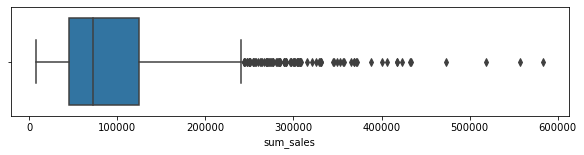

In [76]:
figure(figsize=(10, 2))
sns.boxplot(transaction_customer_sum.sum_sales, orient='h')
plt.show()

Text(0, 0.5, 'Total sales')

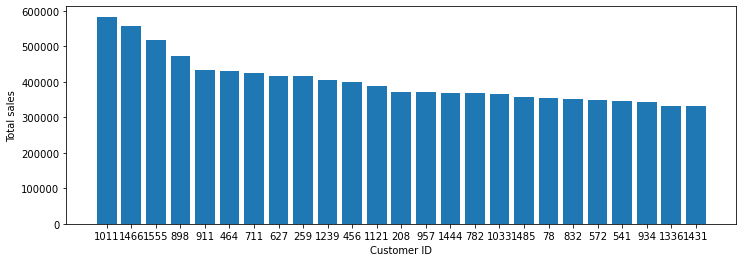

In [77]:
# example: Top customers with largest expenditures

top = 25

heavy_buyer = transaction_customer_sum.sort_values('sum_sales',ascending=False)[:top]

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(range(top),height=heavy_buyer.sum_sales)

axes.set_xticks(range(top))
axes.set_xticklabels(heavy_buyer.customer_id)
axes.set_xlabel('Customer ID')
axes.set_ylabel('Total sales')

In [78]:
# For each customer (customer_id), average per transaction
# 20210705: removed 'quantity'

transaction_customer_avg = pd.pivot_table(transaction, index = 'customer_id',
                       values = ['sales','other_discount',
                                 'coupon_discount','use_other_discount','use_coupon_discount'],
                       aggfunc= np.mean
                      )

new_cols = {'sales':'avg_sales',
            'other_discount':'avg_other_discount',
            'coupon_discount':'avg_coupon_discount',
            'use_other_discount':'avg_use_other_discount',
            'use_coupon_discount':'avg_use_coupon_discount'}

transaction_customer_avg.reset_index(inplace=True)
transaction_customer_avg.rename(columns=new_cols, inplace = True)

transaction_customer_avg.head()

customer_id  avg_coupon_discount  avg_other_discount   avg_sales  \
0            1             2.019876           16.250382   94.001842   
1            2             0.595084           16.830430  102.864033   
2            3             3.091546           22.714227  103.617404   
3            4             0.404773           13.305409  154.423727   
4            5             0.114684           13.657917  130.827146   

   avg_use_coupon_discount  avg_use_other_discount  
0                 0.074427                0.474237  
1                 0.009547                0.427208  
2                 0.075177                0.557447  
3                 0.004545                0.386364  
4                 0.002525                0.366162

In [79]:
# For each customer (customer_id), would like to get the following information:
# monthly transactions, monthly purchase quantities, monthly spending, 
# monthly other discount, monthly coupon discount, monthly frequence of using other discount,
# monthly frequency of using coupon discount

In [80]:
# 20210705: removed 'quantity'

transaction_cus_date = pd.pivot_table(transaction, index=['customer_id','date'],
                                      values = ['item_id','sales','other_discount',
                                                'coupon_discount','use_other_discount','use_coupon_discount'],
                                      aggfunc = {'item_id': lambda x: len(x),
                                                 'sales': sum,
                                                 'other_discount': sum,
                                                 'coupon_discount': sum,
                                                 'use_other_discount': sum,
                                                 'use_coupon_discount': sum}
                                     )
                                      
new_cols = {'item_id': 'ct_trans',
            'sales':'sum_sales',
            'other_discount':'sum_other_discount',
            'coupon_discount':'sum_coupon_discount',
            'use_other_discount':'ct_use_other_discount',
            'use_coupon_discount':'ct_use_coupon_discount'}

#transaction_cus_date.reset_index(inplace=True)
transaction_cus_date.rename(columns=new_cols, inplace = True)

transaction_cus_date.head()

sum_coupon_discount  ct_trans  sum_other_discount  \
customer_id date                                                            
1           2012-02-21                35.62        27              537.84   
            2012-03-08                 0.00        10              305.98   
            2012-03-29                 0.00         8              179.88   
            2012-04-04                17.81        19              331.27   
            2012-04-11                 0.00        14              546.41   

                        sum_sales  ct_use_coupon_discount  \
customer_id date                                            
1           2012-02-21    2603.45                       1   
            2012-03-08    1431.20                       0   
            2012-03-29     691.73                       0   
            2012-04-04    1913.50                       1   
            2012-04-11    1702.28                       0   

                        ct_use_other_discount  
customer_id date                               
1           2012-02-21                     14  
            2012-03-08                      5  
            2012-03-29                      5  
            2012-04-04                      9  
            2012-04-11                     11

In [81]:
customer_trans = pd.DataFrame()
customer_trans['customer_id'] = transaction.customer_id.unique()

# The two lines below made several features "object".
# for f in transaction_cus_date.columns:
#     customer_trans[f] = ''

for f in transaction_cus_date.columns:
    customer_trans[f] = np.nan

for i in customer_trans['customer_id']:
    
    # create the index with the start (the month of first purchase) and end time (2013-06-30)
    first_trans = transaction_cus_date.loc[i].index.min()
    t_index = pd.DatetimeIndex(pd.date_range(start=first_trans, end='2013-06-30', freq="1M"))

    # resample the data to 1 month, aggregate,
    # then reset the index and fill the na's with 0
    customer_trans.iloc[customer_trans[customer_trans['customer_id']==i].index, 1:] =\
        transaction_cus_date.loc[i].resample('M').sum().reindex(t_index).fillna(0).mean().values
            

new_cols = {'sum_coupon_discount':'monthly_cp_disc',
            'ct_trans':'monthly_ct_trans',
            'sum_other_discount':'monthly_other_disc',
            'sum_sales':'monthly_sales',
            'ct_use_coupon_discount':'monthly_freq_cp_disc',
            'ct_use_other_discount':'monthly_freq_other_disc'}

customer_trans.rename(columns=new_cols, inplace = True)      
customer_trans.head()

customer_id  monthly_cp_disc  monthly_ct_trans  monthly_other_disc  \
0         1501        46.997778         19.944444          349.390000   
1          857        66.094444         24.888889          411.246667   
2           67         0.000000         24.611111          275.403889   
3          751         0.593889         37.111111          746.013333   
4          679         0.000000         76.000000         1263.567778   

   monthly_sales  monthly_freq_cp_disc  monthly_freq_other_disc  
0    2408.776667              1.722222                10.555556  
1    2605.804444              1.444444                12.222222  
2    1516.281667              0.000000                10.833333  
3    4987.387222              0.055556                19.888889  
4    8731.938889              0.000000                42.111111

In [82]:
# What kind of products does each customer buy?

it_by_cus_df = \
    transaction.groupby('customer_id')['item_id'].unique().reset_index().rename(columns={'item_id':'it_by_cus'})
#reset_index() converts series to dataframe

it_by_cus_df['len_it_by_cus'] = it_by_cus_df.it_by_cus.map(len)

it_by_cus_df.head()

# Transaction table itself provides limited insights. Need to merge with item table. See later.

customer_id                                          it_by_cus  \
0            1  [4953, 5626, 7808, 8107, 8307, 14054, 17047, 1...   
1            2  [31095, 45231, 45266, 45393, 45502, 7229, 1272...   
2            3  [10975, 13174, 14978, 16086, 16708, 18156, 195...   
3            4  [6121, 10461, 10594, 11816, 12433, 12838, 1324...   
4            5  [7745, 7787, 7798, 10347, 13467, 15633, 20070,...   

   len_it_by_cus  
0            463  
1            352  
2            406  
3            125  
4            490

1. What items were sold at the most/least quantities?
2. What items had the most/least sales?
3. What items had the most/least other discount?
4. What items had the most/least coupon discount?

In [83]:
# For each item (item_id), sum of total transactions

transaction_item_sum = pd.pivot_table(transaction, index = 'item_id',
                       values = ['quantity','sales','other_discount',
                                 'coupon_discount','use_other_discount','use_coupon_discount'],
                       aggfunc=np.sum
                      )

new_cols = {'quantity':'sum_quantity',
            'sales':'sum_sales',
            'other_discount':'sum_other_discount',
            'coupon_discount':'sum_coupon_discount',
            'use_other_discount':'sum_use_other_discount',
            'use_coupon_discount':'sum_use_coupon_discount'}

transaction_item_sum.reset_index(inplace=True)
transaction_item_sum.rename(columns=new_cols, inplace = True)

transaction_item_sum.head()

item_id  sum_coupon_discount  sum_other_discount  sum_quantity  sum_sales  \
0        1                  0.0                 0.0             2     248.62   
1        2                  0.0                 0.0             1      35.26   
2        3                  0.0                 0.0             1      56.64   
3        4                  0.0                 0.0             1      54.85   
4        5                  0.0                 0.0             1      81.57   

   sum_use_coupon_discount  sum_use_other_discount  
0                        0                       0  
1                        0                       0  
2                        0                       0  
3                        0                       0  
4                        0                       0

Text(0, 0.5, 'Total sales')

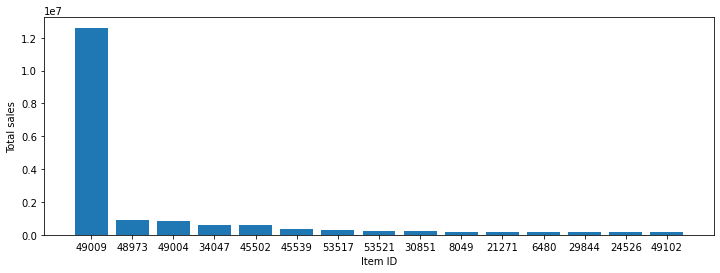

In [84]:
# example: Top sellers (items)

top = 15

top_seller = transaction_item_sum.sort_values('sum_sales',ascending=False)[:top]

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(range(top),height=top_seller.sum_sales)

axes.set_xticks(range(top))
axes.set_xticklabels(top_seller.item_id)
axes.set_xlabel('Item ID')
axes.set_ylabel('Total sales')

In [85]:
# Who bought item_id 49009? 919 customers bought it. 919 customers bought it. This item is popular.
transaction[transaction.item_id==49009].customer_id.nunique()

919

1. Transaction table has 1.3 millon records. 
    - 1582 unique customers vs. 1428 unique customers in train table vs. 760 unique customers in demographic table.
    - 74063 unique items vs. 74066 unique items in item table.
    - About 80% of the transactions are single item purchases. 1.2% of the transcations are bulk purchases (e.g., quantity > 100).
    - Heavy buyers identified (transaction_customer_sum).
    - Popluar items identified (transaction_item_sum).
2. Created two new binary features for transaction table: use_other_discount, use_coupon_discount
3. Three new dataframes to gain insights of customer purchase behavior (customer_id as primary key):
    - transaction_customer_avg (transaction data averaged by each transaction)
    - customer_trans (transaction data aggregated monthly)

## More insights by merging tables

### Merging campaign table with train table

It is useful to see more of the campaign information aside from start/end time and type of campaign. For example, we may be interested in the following questions:
1. How many coupons (unique coupon_id) were issued in each campaign?
2. How many customers did each campaign send coupons to?
3. Following the question above, how many of these customers redeemed coupons? This needs further definition because each customer may deem more then one coupon in one campaign or deem different number of coupons in different campaigns. I think we don't need to dig deep here because later we will examine the relationship between features and redemption_status (target variable). 

Among all the tables provided, campaign_id only shows up in the train table and the campaign table. Therefore, we have to rely on the train table to derive more insights related to campaign information.

Text(0, 0.5, 'Number of coupons')

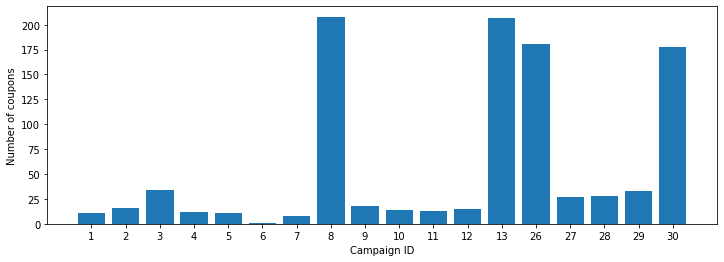

In [86]:
# How many coupons (unique coupon_id) are issued in each campaign
cp_in_camp_df = \
    train.groupby('campaign_id')['coupon_id'].nunique().reset_index().\
    rename(columns={'coupon_id':'cp_in_camp'})

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(cp_in_camp_df.index, cp_in_camp_df.cp_in_camp)

axes.set_xticks(cp_in_camp_df.index)
axes.set_xticklabels(cp_in_camp_df.campaign_id)
axes.set_xlabel('Campaign ID')
axes.set_ylabel('Number of coupons')

In [87]:
cp_in_camp_df.head()

campaign_id  cp_in_camp
0            1          11
1            2          16
2            3          34
3            4          12
4            5          11

Text(0, 0.5, 'Number of customers')

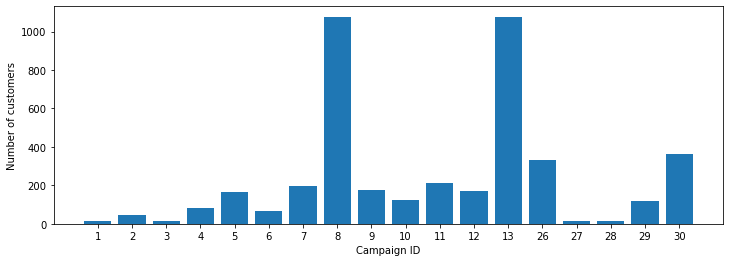

In [88]:
# How many customers has each campaign sent coupons to
cus_in_camp_df = \
    train.groupby('campaign_id')['customer_id'].nunique().reset_index().\
    rename(columns={'customer_id':'cus_in_camp'})

fig, axes = plt.subplots(figsize=(12, 4))
axes.bar(cus_in_camp_df.index, cus_in_camp_df.cus_in_camp)

axes.set_xticks(cus_in_camp_df.index)
axes.set_xticklabels(cus_in_camp_df.campaign_id)
axes.set_xlabel('Campaign ID')
axes.set_ylabel('Number of customers')

In [89]:
cus_in_camp_df.head()

campaign_id  cus_in_camp
0            1           13
1            2           48
2            3           12
3            4           81
4            5          166

In [90]:
train_raw = pd.merge(train, cp_in_camp_df, on='campaign_id', how='left') 

In [91]:
train_raw = pd.merge(train_raw, cus_in_camp_df, on='campaign_id', how='left') 

In [92]:
train_raw = pd.merge(train_raw, campaign, on='campaign_id', how='left') 

In [93]:
train_raw.head()

id  campaign_id  coupon_id  customer_id  redemption_status  cp_in_camp  \
0   1           13         27         1053                  0         207   
1   2           13        116           48                  0         207   
2   6            9        635          205                  0          18   
3   7           13        644         1050                  0         207   
4   9            8       1017         1489                  0         208   

   cus_in_camp campaign_type start_date   end_date  campaign_duration  
0         1077             X 2013-05-19 2013-07-05                 47  
1         1077             X 2013-05-19 2013-07-05                 47  
2          176             Y 2013-03-11 2013-04-12                 32  
3         1077             X 2013-05-19 2013-07-05                 47  
4         1076             X 2013-02-16 2013-04-05                 48

### Merging coupon table & item table with train table

There are challenges for both coupon table and item table to merge with train table. 
- For coupon table, aggregation needs to be performed on coupon_id so that the conpon_id column has unique values.
- For item table, it cannot merge with train table because item_id doesn't exist in train table. Instead, the information in item table needs to be relayed through coupon table.

Create a dataframe that can address the following questions:
1. How many items are in each coupon (num_it_in_cp, num_it_in_cp_bin)?
2. How many brands does each coupon cover?
    - Mode of brand? (error: module 'statistics' has no attribute 'multimode')
    - Instead of mode, can try to create categorical features, follow by proper encoding (too many levels, dummy won't work)
3. How many categories does each coupon cover? 
    - Mode of category? 
4. How many brand types does each coupon cover?
    - Mode of brand_type?

In [94]:
coupon_item = pd.merge(coupon, item, on='item_id', how='left')
coupon_item.drop(columns='num_it_in_cp', inplace=True)
coupon_item.head()

coupon_id  item_id num_it_in_cp_bin  freq_it_in_cp  brand   brand_type  \
0        105       37         (10, 50]              4     56        Local   
1        107       75         (10, 50]              5     56        Local   
2        494       76         (10, 50]              4    209  Established   
3        522       77        (50, 100]              7    278  Established   
4        518       77        (50, 100]              7    278  Established   

  category  num_it_in_brand     brand_bin  
0  Grocery            10480  (100, 11000]  
1  Grocery            10480  (100, 11000]  
2  Grocery              295  (100, 11000]  
3  Grocery              547  (100, 11000]  
4  Grocery              547  (100, 11000]

In [95]:
coupon_item = coupon_item.iloc[:,:-2]

In [96]:
coupon_item = coupon_item.drop(columns=['freq_it_in_cp'])

In [97]:
coupon_item.head()

coupon_id  item_id num_it_in_cp_bin  brand   brand_type category
0        105       37         (10, 50]     56        Local  Grocery
1        107       75         (10, 50]     56        Local  Grocery
2        494       76         (10, 50]    209  Established  Grocery
3        522       77        (50, 100]    278  Established  Grocery
4        518       77        (50, 100]    278  Established  Grocery

In [98]:
coupon_item_sub1 = pd.pivot_table(coupon_item, index = 'coupon_id',
                       values = ['brand', 'brand_type','category'],
                       aggfunc= lambda x: len(set(x))
                      )

new_cols = {'brand':'ct_brand',
            'brand_type': 'ct_brand_type',
            'category':'ct_category'}

coupon_item_sub1.reset_index(inplace=True)
coupon_item_sub1.rename(columns=new_cols, inplace = True)

coupon_item_sub1.head()

coupon_id  ct_brand  ct_brand_type  ct_category
0          1         3              1            2
1          2         1              1            1
2          3         2              1            1
3          4         1              1            1
4          5         1              1            1

In [99]:
coupon_item_sub1.ct_brand.value_counts()

1       974
2        93
3        27
5         3
80        2
1185      1
4         1
6         1
15        1
59        1
126       1
1187      1
170       1
216       1
224       1
371       1
383       1
390       1
520       1
521       1
955       1
128       1
Name: ct_brand, dtype: int64

Most coupons (87%) contain just 1 brand. A few coupons contain a large number of brands. Here I transformed ct_brand to a flag feature where 0 - one brand, 1 - two brands and more.

In [100]:
coupon_item_sub1.loc[coupon_item_sub1[coupon_item_sub1.ct_brand==1].index,\
                 ['ct_brand']] = 0
coupon_item_sub1.loc[coupon_item_sub1[coupon_item_sub1.ct_brand>1].index,\
                 ['ct_brand']] = 1

Since most coupons contain one brand, we can find which brand it contains. For the other 13% of the coupons that contain more than one brand, it's technically possible to identify the mode, whether single mode or multi-mode. However, it is unclear if this effort will add value. Instead, I assigned "multiple" to coupons containing more than one brand.   

In [101]:
coupon_item_sub1 = coupon_item_sub1.assign(brand=
    coupon_item.groupby('coupon_id')['brand'].unique().map(lambda x:
                                                           'multiple' if len(x)>1 else x[0]).values
    )

coupon_item_sub1.head()

coupon_id  ct_brand  ct_brand_type  ct_category     brand
0          1         1              1            2  multiple
1          2         0              1            1      2084
2          3         1              1            1  multiple
3          4         0              1            1       544
4          5         0              1            1      5357

In [102]:
coupon_item_sub1.ct_category.value_counts()

1     1065
2       35
7        5
6        3
15       2
5        2
3        2
14       1
8        1
Name: ct_category, dtype: int64

Most coupons (95%) contain just 1 category. Similar to how ct_brand was handled, I transformed ct_category to a flag feature where 0 - one category, 1 - two categories and more. Also, I assigned "multiple" to coupons containing more than one category.

In [103]:
coupon_item_sub1.loc[coupon_item_sub1[coupon_item_sub1.ct_category==1].index,\
                 ['ct_category']] = 0
coupon_item_sub1.loc[coupon_item_sub1[coupon_item_sub1.ct_category>1].index,\
                 ['ct_category']] = 1

coupon_item_sub1 = coupon_item_sub1.assign(category=
    coupon_item.groupby('coupon_id')['category'].unique().map(lambda x:
                                                           'multiple' if len(x)>1 else x[0]).values
    )

coupon_item_sub1.head()

coupon_id  ct_brand  ct_brand_type  ct_category     brand        category
0          1         1              1            1  multiple        multiple
1          2         0              1            0      2084         Grocery
2          3         1              1            0  multiple         Grocery
3          4         0              1            0       544         Grocery
4          5         0              1            0      5357  Pharmaceutical

In [104]:
coupon_item_sub1.ct_brand_type.value_counts()

1    1091
2      25
Name: ct_brand_type, dtype: int64

Most coupons (98%) contain just 1 brand_type. The process of creating new brand_type feature is similar to brand and category, except that ct_brand_type is dropped.

In [105]:
coupon_item_sub1.drop(columns='ct_brand_type', inplace=True)


coupon_item_sub1 = coupon_item_sub1.assign(brand_type=
    coupon_item.groupby('coupon_id')['brand_type'].unique().map(lambda x:
                                                           'multiple' if len(x)>1 else x[0]).values
    )

coupon_item_sub1.head()

coupon_id  ct_brand  ct_category     brand        category   brand_type
0          1         1            1  multiple        multiple  Established
1          2         0            0      2084         Grocery  Established
2          3         1            0  multiple         Grocery  Established
3          4         0            0       544         Grocery  Established
4          5         0            0      5357  Pharmaceutical  Established

In [106]:
# Add num_it_in_cp_bin from coupon table

coupon_item_sub1 = coupon_item_sub1.assign(num_it_in_cp_bin=
    coupon_item.groupby('coupon_id')['num_it_in_cp_bin'].unique().map(lambda x:
                                                                  x[0]).values)

coupon_item_sub1.head()

coupon_id  ct_brand  ct_category     brand        category   brand_type  \
0          1         1            1  multiple        multiple  Established   
1          2         0            0      2084         Grocery  Established   
2          3         1            0  multiple         Grocery  Established   
3          4         0            0       544         Grocery  Established   
4          5         0            0      5357  Pharmaceutical  Established   

  num_it_in_cp_bin  
0         (10, 50]  
1           (0, 5]  
2         (10, 50]  
3         (10, 50]  
4          (5, 10]

In [107]:
train_raw = pd.merge(train_raw, coupon_item_sub1, on='coupon_id', how='left')

train_raw.head()

id  campaign_id  coupon_id  customer_id  redemption_status  cp_in_camp  \
0   1           13         27         1053                  0         207   
1   2           13        116           48                  0         207   
2   6            9        635          205                  0          18   
3   7           13        644         1050                  0         207   
4   9            8       1017         1489                  0         208   

   cus_in_camp campaign_type start_date   end_date  campaign_duration  \
0         1077             X 2013-05-19 2013-07-05                 47   
1         1077             X 2013-05-19 2013-07-05                 47   
2          176             Y 2013-03-11 2013-04-12                 32   
3         1077             X 2013-05-19 2013-07-05                 47   
4         1076             X 2013-02-16 2013-04-05                 48   

   ct_brand  ct_category     brand        category   brand_type  \
0         1            0  multiple         Grocery  Established   
1         0            0        56         Grocery        Local   
2         0            0       560  Pharmaceutical  Established   
3         0            0       611         Grocery  Established   
4         0            0      1558         Grocery  Established   

  num_it_in_cp_bin  
0      (100, 1000]  
1           (0, 5]  
2        (50, 100]  
3           (0, 5]  
4         (10, 50]

### Merging demographic table with train table

In [108]:
demog.head()

customer_id age_range marital_status  rented family_size no_of_children  \
0            1       70+        Married       0           2        unknown   
1            6     46-55        Married       0           2        unknown   
2            7     26-35        unknown       0           3              1   
3            8     26-35        unknown       0           4              2   
4           10     46-55         Single       0           1        unknown   

   income_bracket  
0               4  
1               5  
2               3  
3               6  
4               5

In [109]:
train_raw = pd.merge(train_raw, demog, on='customer_id', how='left')

train_raw.head()

id  campaign_id  coupon_id  customer_id  redemption_status  cp_in_camp  \
0   1           13         27         1053                  0         207   
1   2           13        116           48                  0         207   
2   6            9        635          205                  0          18   
3   7           13        644         1050                  0         207   
4   9            8       1017         1489                  0         208   

   cus_in_camp campaign_type start_date   end_date  campaign_duration  \
0         1077             X 2013-05-19 2013-07-05                 47   
1         1077             X 2013-05-19 2013-07-05                 47   
2          176             Y 2013-03-11 2013-04-12                 32   
3         1077             X 2013-05-19 2013-07-05                 47   
4         1076             X 2013-02-16 2013-04-05                 48   

   ct_brand  ct_category     brand        category   brand_type  \
0         1            0  multiple         Grocery  Established   
1         0            0        56         Grocery        Local   
2         0            0       560  Pharmaceutical  Established   
3         0            0       611         Grocery  Established   
4         0            0      1558         Grocery  Established   

  num_it_in_cp_bin age_range marital_status  rented family_size  \
0      (100, 1000]     46-55        unknown     0.0           1   
1           (0, 5]     36-45        Married     0.0           2   
2        (50, 100]     46-55        Married     0.0           2   
3           (0, 5]       NaN            NaN     NaN         NaN   
4         (10, 50]     46-55        Married     0.0           2   

  no_of_children  income_bracket  
0        unknown             5.0  
1        unknown             3.0  
2        unknown             7.0  
3            NaN             NaN  
4        unknown             3.0

### Utilizing information from transaction table

**Dive deeper into customer purchase behavior**

In [110]:
transaction_item = pd.merge(transaction, item, on='item_id', how='left')
transaction_item.head()

date  customer_id  item_id  quantity   sales  other_discount  \
0 2012-01-02         1501    26830         1   35.26           10.69   
1 2012-01-02         1501    54253         1   53.43           13.89   
2 2012-01-02         1501    31962         1  106.50           14.25   
3 2012-01-02         1501    33647         1   67.32            0.00   
4 2012-01-02         1501    48199         1   71.24           28.14   

   coupon_discount  use_other_discount  use_coupon_discount  brand  \
0              0.0                   1                    0     56   
1              0.0                   1                    0     56   
2              0.0                   1                    0    524   
3              0.0                   0                    0   1134   
4              0.0                   1                    0    524   

    brand_type          category  num_it_in_brand     brand_bin  
0        Local  Natural Products            10480  (100, 11000]  
1        Local  Natural Products            10480  (100, 11000]  
2  Established           Grocery              171  (100, 11000]  
3  Established           Grocery              296  (100, 11000]  
4  Established           Grocery              171  (100, 11000]

In [111]:
customer_item = pd.DataFrame()
customer_item['customer_id'] = transaction_item['customer_id'].unique()

In [112]:
customer_brand_type_df =\
    transaction_item.groupby('customer_id')['brand_type'].value_counts().unstack()

customer_brand_type_df =\
customer_brand_type_df.div(customer_brand_type_df.sum(axis=1), axis=0)

customer_brand_type_df.reset_index(inplace=True)

customer_item = pd.merge(customer_item, customer_brand_type_df, on='customer_id', how='left')
customer_item.drop(columns=['Local'],axis=1,inplace=True)
customer_item.head()

customer_id  Established
0         1501     0.834711
1          857     0.834395
2           67     0.620767
3          751     0.736527
4          679     0.902047

In [113]:
customer_category_df =\
    transaction_item.groupby('customer_id')['category'].value_counts().unstack()

customer_category_df =\
customer_category_df.div(customer_category_df.sum(axis=1), axis=0)

customer_category_df.reset_index(inplace=True)

customer_item = pd.merge(customer_item, customer_category_df, on='customer_id', how='left')

customer_item.fillna(0, inplace=True)

customer_item.head()

customer_id  Established   Alcohol    Bakery  Dairy, Juices & Snacks  \
0         1501     0.834711  0.000000  0.002755                0.000000   
1          857     0.834395  0.000000  0.019108                0.004246   
2           67     0.620767  0.000000  0.000000                0.022573   
3          751     0.736527  0.028443  0.007485                0.017964   
4          679     0.902047  0.000000  0.000000                0.000000   

   Flowers & Plants  Fuel    Garden   Grocery      Meat  Miscellaneous  \
0          0.000000   0.0  0.000000  0.754821  0.019284       0.002755   
1          0.002123   0.0  0.002123  0.711253  0.040340       0.002123   
2          0.000000   0.0  0.000000  0.769752  0.042889       0.002257   
3          0.001497   0.0  0.004491  0.648204  0.019461       0.000000   
4          0.000000   0.0  0.000000  0.808480  0.013889       0.000000   

   Natural Products  Packaged Meat  Pharmaceutical  Prepared Food  \
0          0.066116       0.044077        0.099174       0.008264   
1          0.025478       0.048832        0.106157       0.019108   
2          0.051919       0.036117        0.072235       0.002257   
3          0.049401       0.046407        0.161677       0.007485   
4          0.022661       0.046053        0.076023       0.019737   

   Restauarant    Salads   Seafood  Skin & Hair Care    Travel  \
0          0.0  0.000000  0.002755          0.000000  0.000000   
1          0.0  0.002123  0.002123          0.014862  0.000000   
2          0.0  0.000000  0.000000          0.000000  0.000000   
3          0.0  0.000000  0.002994          0.004491  0.000000   
4          0.0  0.000000  0.012427          0.000000  0.000731   

   Vegetables (cut)  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

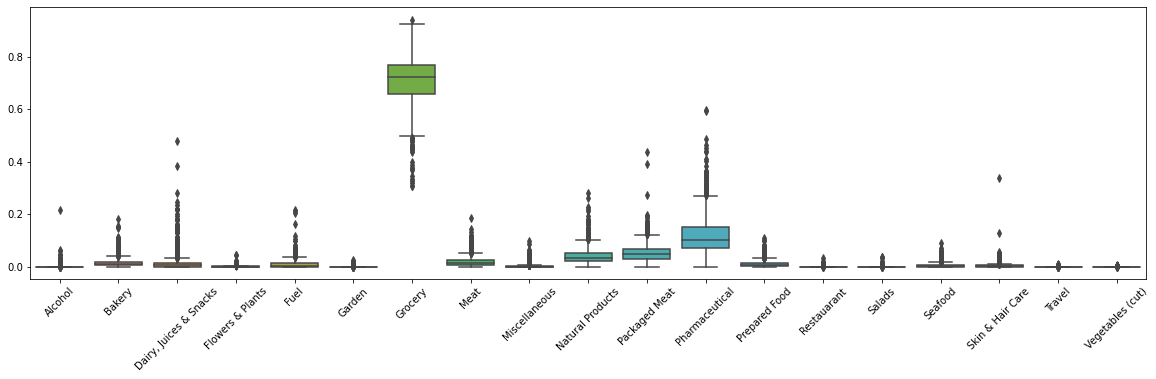

In [114]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=customer_item.iloc[:,2:])
plt.xticks(rotation=45)
plt.show()

#fig, axes = plt.subplots(figsize=(20, 5))
#axes = sns.boxplot(data=customer_item.iloc[:,2:])
#axes.set_xticklabels(ax.get_xticklabels(),rotation=30)

#plt.figure(figsize=(10,5))
#ax = sns.boxplot(data=customer_item.iloc[:,2:])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [115]:
old_cols = list(customer_item.columns)
old_cols.remove('customer_id')

new_cols = ['cus_'+i for i in old_cols]
new_cols = dict(zip(old_cols, new_cols))

customer_item.rename(columns=new_cols, inplace=True)
customer_item.head()

customer_id  cus_Established  cus_Alcohol  cus_Bakery  \
0         1501         0.834711     0.000000    0.002755   
1          857         0.834395     0.000000    0.019108   
2           67         0.620767     0.000000    0.000000   
3          751         0.736527     0.028443    0.007485   
4          679         0.902047     0.000000    0.000000   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000              0.000000       0.0    0.000000   
1                    0.004246              0.002123       0.0    0.002123   
2                    0.022573              0.000000       0.0    0.000000   
3                    0.017964              0.001497       0.0    0.004491   
4                    0.000000              0.000000       0.0    0.000000   

   cus_Grocery  cus_Meat  cus_Miscellaneous  cus_Natural Products  \
0     0.754821  0.019284           0.002755              0.066116   
1     0.711253  0.040340           0.002123              0.025478   
2     0.769752  0.042889           0.002257              0.051919   
3     0.648204  0.019461           0.000000              0.049401   
4     0.808480  0.013889           0.000000              0.022661   

   cus_Packaged Meat  cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  \
0           0.044077            0.099174           0.008264              0.0   
1           0.048832            0.106157           0.019108              0.0   
2           0.036117            0.072235           0.002257              0.0   
3           0.046407            0.161677           0.007485              0.0   
4           0.046053            0.076023           0.019737              0.0   

   cus_Salads  cus_Seafood  cus_Skin & Hair Care  cus_Travel  \
0    0.000000     0.002755              0.000000    0.000000   
1    0.002123     0.002123              0.014862    0.000000   
2    0.000000     0.000000              0.000000    0.000000   
3    0.000000     0.002994              0.004491    0.000000   
4    0.000000     0.012427              0.000000    0.000731   

   cus_Vegetables (cut)  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

1. Most customers buy Grocery items. Pharmaceutical items are commonly purchased items as well. 
2. Created a new dataframe customer_item to characterize the purchase preference of each customer.

In [116]:
train_raw_trans = pd.merge(train, transaction_customer_avg, on='customer_id', how='left')
train_raw_trans = pd.merge(train_raw_trans, customer_trans, on='customer_id', how='left')
train_raw_trans = pd.merge(train_raw_trans, customer_item, on='customer_id', how='left')
train_raw_trans.head()

id  campaign_id  coupon_id  customer_id  redemption_status  \
0   1           13         27         1053                  0   
1   2           13        116           48                  0   
2   6            9        635          205                  0   
3   7           13        644         1050                  0   
4   9            8       1017         1489                  0   

   avg_coupon_discount  avg_other_discount   avg_sales  \
0             0.287258           33.168935  184.260484   
1             3.215039           27.699169  234.247013   
2             2.212082           17.795660  121.094495   
3             0.751477           16.655570   98.276034   
4             0.471548           20.524733  120.636103   

   avg_use_coupon_discount  avg_use_other_discount  monthly_cp_disc  \
0                 0.003226                0.538710         4.947222   
1                 0.031169                0.542857        77.361875   
2                 0.087629                0.471134       134.107500   
3                 0.008439                0.506329        10.476471   
4                 0.017794                0.500000        17.667333   

   monthly_ct_trans  monthly_other_disc  monthly_sales  monthly_freq_cp_disc  \
0         16.888889          564.277222    3107.577222              0.055556   
1         24.062500          666.511250    5636.568750              0.750000   
2         60.625000         1078.861875    7341.353750              5.312500   
3         13.941176          232.198235    1370.083529              0.117647   
4         37.133333          762.700000    4489.698000              0.666667   

   monthly_freq_other_disc  cus_Established  cus_Alcohol  cus_Bakery  \
0                 9.166667         0.535484     0.000000    0.000000   
1                13.062500         0.755844     0.000000    0.025974   
2                28.562500         0.814433     0.000000    0.008247   
3                 7.058824         0.531646     0.004219    0.042194   
4                18.533333         0.713523     0.000000    0.008897   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000                   0.0  0.048387         0.0   
1                    0.002597                   0.0  0.002597         0.0   
2                    0.007216                   0.0  0.000000         0.0   
3                    0.000000                   0.0  0.000000         0.0   
4                    0.000000                   0.0  0.024911         0.0   

   cus_Grocery  cus_Meat  cus_Miscellaneous  cus_Natural Products  \
0     0.690323  0.061290           0.000000              0.022581   
1     0.618182  0.033766           0.007792              0.054545   
2     0.731959  0.064948           0.001031              0.052577   
3     0.780591  0.000000           0.000000              0.004219   
4     0.718861  0.019573           0.021352              0.017794   

   cus_Packaged Meat  cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  \
0           0.093548            0.067742           0.003226              0.0   
1           0.080519            0.148052           0.010390              0.0   
2           0.022680            0.088660           0.017526              0.0   
3           0.037975            0.113924           0.012658              0.0   
4           0.103203            0.085409           0.000000              0.0   

   cus_Salads  cus_Seafood  cus_Skin & Hair Care  cus_Travel  \
0    0.000000     0.012903              0.000000         0.0   
1    0.002597     0.012987              0.000000         0.0   
2    0.000000     0.001031              0.004124         0.0   
3    0.000000     0.000000              0.004219         0.0   
4    0.000000     0.000000              0.000000         0.0   

   cus_Vegetables (cut)  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

# Exploratory data analysis

## All features sans transaction features

Notes on further feature engineering:
1. campaign start_date and end_date may be used to create date-time features.
2. categorical features to be encoded: campaign_type, brand, category, brand_type, age_range, marital_status, rented, family_size, no_of_children, income_bracket

In [117]:
train_raw.head() 
# features related to customer transactions is in train_raw_trans

id  campaign_id  coupon_id  customer_id  redemption_status  cp_in_camp  \
0   1           13         27         1053                  0         207   
1   2           13        116           48                  0         207   
2   6            9        635          205                  0          18   
3   7           13        644         1050                  0         207   
4   9            8       1017         1489                  0         208   

   cus_in_camp campaign_type start_date   end_date  campaign_duration  \
0         1077             X 2013-05-19 2013-07-05                 47   
1         1077             X 2013-05-19 2013-07-05                 47   
2          176             Y 2013-03-11 2013-04-12                 32   
3         1077             X 2013-05-19 2013-07-05                 47   
4         1076             X 2013-02-16 2013-04-05                 48   

   ct_brand  ct_category     brand        category   brand_type  \
0         1            0  multiple         Grocery  Established   
1         0            0        56         Grocery        Local   
2         0            0       560  Pharmaceutical  Established   
3         0            0       611         Grocery  Established   
4         0            0      1558         Grocery  Established   

  num_it_in_cp_bin age_range marital_status  rented family_size  \
0      (100, 1000]     46-55        unknown     0.0           1   
1           (0, 5]     36-45        Married     0.0           2   
2        (50, 100]     46-55        Married     0.0           2   
3           (0, 5]       NaN            NaN     NaN         NaN   
4         (10, 50]     46-55        Married     0.0           2   

  no_of_children  income_bracket  
0        unknown             5.0  
1        unknown             3.0  
2        unknown             7.0  
3            NaN             NaN  
4        unknown             3.0

In [118]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 78369 non-null  int64         
 1   campaign_id        78369 non-null  int64         
 2   coupon_id          78369 non-null  int64         
 3   customer_id        78369 non-null  int64         
 4   redemption_status  78369 non-null  int64         
 5   cp_in_camp         78369 non-null  int64         
 6   cus_in_camp        78369 non-null  int64         
 7   campaign_type      78369 non-null  object        
 8   start_date         78369 non-null  datetime64[ns]
 9   end_date           78369 non-null  datetime64[ns]
 10  campaign_duration  78369 non-null  int64         
 11  ct_brand           78369 non-null  int64         
 12  ct_category        78369 non-null  int64         
 13  brand              78369 non-null  object        
 14  catego

In [119]:
1- 43661/78369

0.4428791996835484

44% of the customers have missing demographic information. If we account for the observations where the level is "unknown" (43% of the other 56% customers are missing marital_status, and 71% of the other 56% customers are missing no_of_children), the missing value reaches 68% for marital_status and 84% for no_of_children. At this high level of missing value, it may not be useful to include these two features. Therefore, I dropped them from train_raw. For the 44% of the customers that miss other demographic information, I created level "unknown" to fill in the missing values.

In [120]:
train_raw.drop(columns=['marital_status','no_of_children'], inplace=True)
train_raw.fillna('unknown', inplace=True)

In [121]:
cat_features = ['campaign_type', 'ct_brand','ct_category',\
                'brand', 'category', 'brand_type',\
                'num_it_in_cp_bin', 'age_range', 'rented',\
                'family_size', 'income_bracket']
num_features = ['cp_in_camp', 'cus_in_camp', 'campaign_duration']

### Categorical features vs. redemption_status

In [122]:
for f in cat_features:
    print('-------Value counts of {} in train_raw------\n'.format(f))
    print(train_raw[f].value_counts(), '\n')

-------Value counts of campaign_type in train_raw------

X    57684
Y    20685
Name: campaign_type, dtype: int64 

-------Value counts of ct_brand in train_raw------

0    69004
1     9365
Name: ct_brand, dtype: int64 

-------Value counts of ct_category in train_raw------

0    74010
1     4359
Name: ct_category, dtype: int64 

-------Value counts of brand in train_raw------

56          15627
multiple     9365
686          1824
1134         1566
946          1430
            ...  
833            25
1427           17
706            17
4674           17
819            17
Name: brand, Length: 265, dtype: int64 

-------Value counts of category in train_raw------

Grocery                   50677
Pharmaceutical            16715
multiple                   4359
Packaged Meat              1891
Prepared Food              1141
Dairy, Juices & Snacks     1102
Seafood                     859
Natural Products            616
Bakery                      573
Meat                        188
Flowers &

In [123]:
# necessary for plot_categorical to work on "brand", "rented", "family_size" and 'income_bracket'
# (they have a mixture of numerical and string levels)
train_raw['brand'] = train_raw['brand'].map(lambda x: str(x)+'b')
train_raw['rented'] = train_raw['rented'].map(lambda x:
                                              'No' if x==0.0 else
                                              ('Yes' if x==1.0 else x))
train_raw['family_size'] =\
    train_raw['family_size'].map(lambda x: 'fam_size_'+str(x))
train_raw['income_bracket'] =\
    train_raw['income_bracket'].map(lambda x:
                                    'income_'+str(x)[:-2] if '.' in str(x)
                                    else 'income_'+str(x))

# necessary for plot_categorical to work on "num_it_in_cp_bin"
# (num_it_in_cp_bin was an Interval object)
train_raw.num_it_in_cp_bin = \
    train_raw.num_it_in_cp_bin.map(lambda x: str(x))

train_raw.head()

id  campaign_id  coupon_id  customer_id  redemption_status  cp_in_camp  \
0   1           13         27         1053                  0         207   
1   2           13        116           48                  0         207   
2   6            9        635          205                  0          18   
3   7           13        644         1050                  0         207   
4   9            8       1017         1489                  0         208   

   cus_in_camp campaign_type start_date   end_date  campaign_duration  \
0         1077             X 2013-05-19 2013-07-05                 47   
1         1077             X 2013-05-19 2013-07-05                 47   
2          176             Y 2013-03-11 2013-04-12                 32   
3         1077             X 2013-05-19 2013-07-05                 47   
4         1076             X 2013-02-16 2013-04-05                 48   

   ct_brand  ct_category      brand        category   brand_type  \
0         1            0  multipleb         Grocery  Established   
1         0            0        56b         Grocery        Local   
2         0            0       560b  Pharmaceutical  Established   
3         0            0       611b         Grocery  Established   
4         0            0      1558b         Grocery  Established   

  num_it_in_cp_bin age_range   rented       family_size  income_bracket  
0      (100, 1000]     46-55       No        fam_size_1        income_5  
1           (0, 5]     36-45       No        fam_size_2        income_3  
2        (50, 100]     46-55       No        fam_size_2        income_7  
3           (0, 5]   unknown  unknown  fam_size_unknown  income_unknown  
4         (10, 50]     46-55       No        fam_size_2        income_3

In [124]:
def plot_categorical(df, feature):

    feature_df = df.groupby(feature)["redemption_status"].sum().reset_index()
    feature_df['Sum'] = df.groupby(feature)["redemption_status"].count().values
    feature_df['Redeem_pct'] = feature_df.redemption_status.div(feature_df['Sum'])*100

    if len(feature_df[feature])>15:
        print('{} has >15 levels; no plot generated'.format(feature))
        return None
    else:
        fig, axes = plt.subplots(figsize=(12, 4))
        plt.bar(feature_df[feature], feature_df.Redeem_pct)
        if len(feature_df[feature])>5:
            plt.xticks(feature_df[feature], feature_df[feature],rotation='vertical')
        else:
            plt.xticks(feature_df[feature], feature_df[feature])
 
        plt.xlabel(feature)
        plt.ylabel('Redemption percentage (%)')

        labels = [str(round(i,2))+"%" for i in feature_df.Redeem_pct]

        for i in range(len(labels)):
            plt.text(feature_df[feature][i], feature_df.Redeem_pct[i], labels[i], ha='center', va='bottom')

        plt.show()

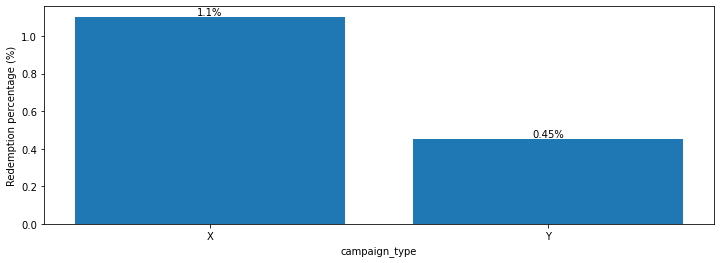

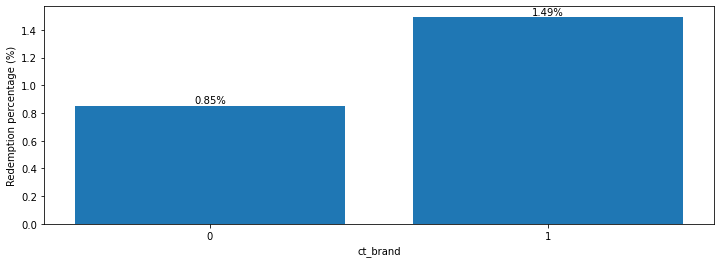

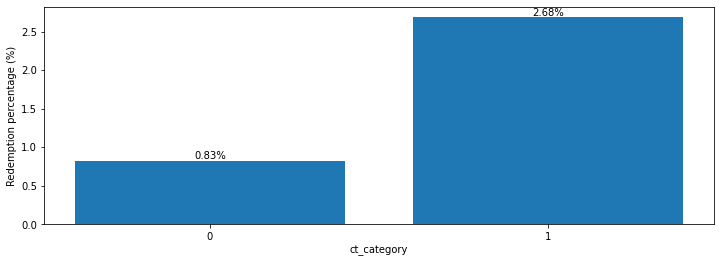

brand has >15 levels; no plot generated


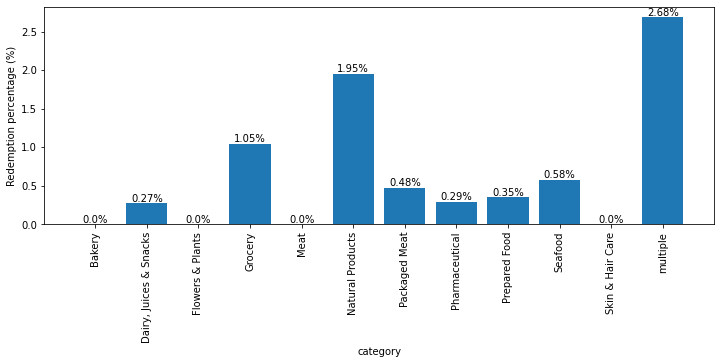

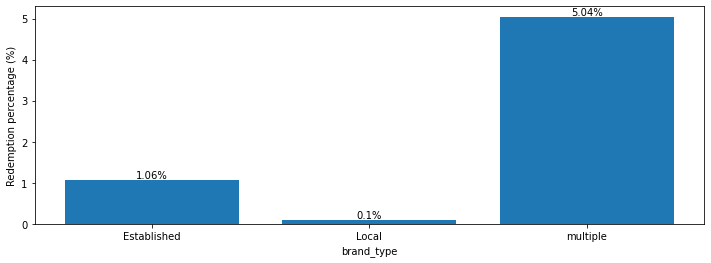

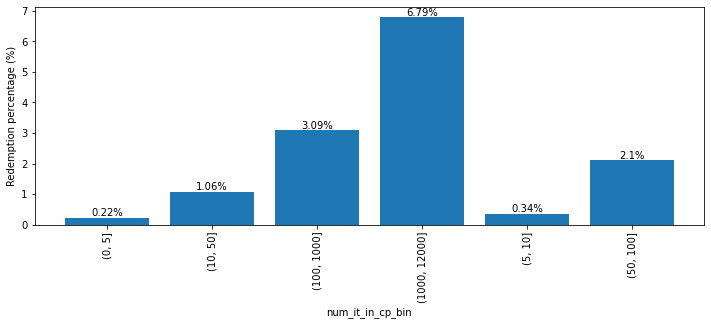

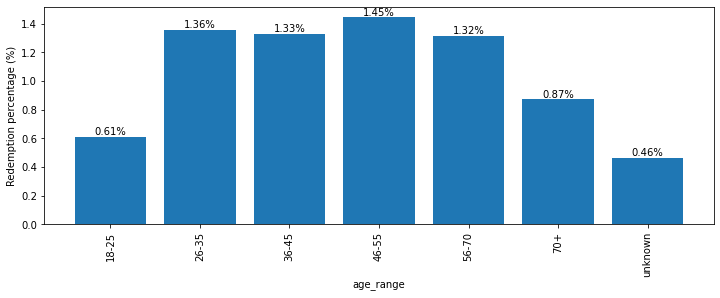

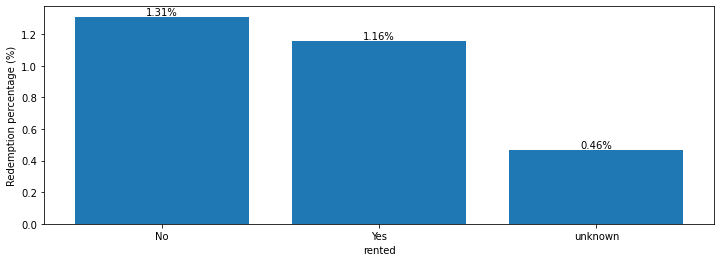

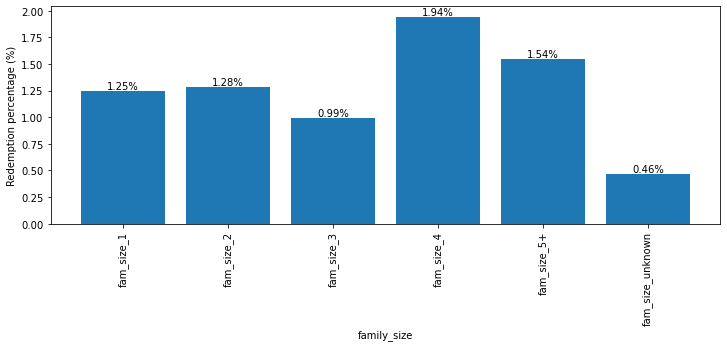

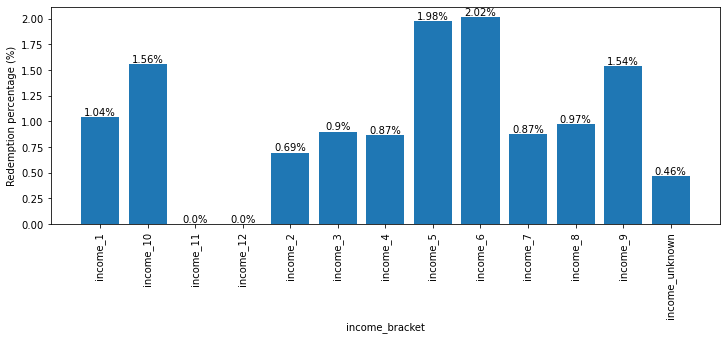

In [125]:
for f in cat_features:
    plot_categorical(train_raw, f)

- campaign_type: X has two-fold higher redemption rate than Y.
- ct_brand: If a coupon contains more than one brand, it has 75% more change to be redeemed.
- ct_category: Coupons covering more than one category have three times higher redemption rate.
- category: "multiple" and "Natural Products" show higher redemption rate. No redemption is observed for "Bakery", "Flowers & Plants", "Meat", and "Skin & Hair Care".
- brand_type: redemption rate is "multiple" > "Established" > "Local"
- num_it_in_cp_bin: The more items a coupon contains, the higher redemption rate the conpon is, as one may expect.
- age_range: "unknown", "18-25", and "70+" have lower redemption rate.
- rented: "unknown" has lower redemption rate.
- family_size: trend is unclear.
- income_bracket: the two highest income brackets do not redeem coupons; treand is unclear for other brackets.

In [126]:
# Here we can further use chi-squared statistical testing to see 
# if the target variable is dependent on each categorical feature 
# It requires at least 5 observations in each cell of the contingency
# table, which cannot be met with our highly imbalanced data.

# Here is an example with num_it_in_cp_bin (visually observed correlation):

cat_f = 'num_it_in_cp_bin'

cat_f_crosstab = pd.crosstab(train_raw['redemption_status'],
                            train_raw[cat_f], 
                            margins = False)

from scipy.stats import chi2_contingency

# Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
stat, p, dof, expected = chi2_contingency(cat_f_crosstab)

# select significance value
alpha = 0.05

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')

significance=0.050, p=0.000
Variables are associated (reject H0)


In [127]:
# Here is an example with family_size (trend is unclear):

cat_f = 'family_size'

cat_f_crosstab = pd.crosstab(train_raw['redemption_status'],
                            train_raw[cat_f], 
                            margins = False)

from scipy.stats import chi2_contingency

# Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
stat, p, dof, expected = chi2_contingency(cat_f_crosstab)

# select significance value
alpha = 0.05

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')
    
print(cat_f_crosstab)

significance=0.050, p=0.000
Variables are associated (reject H0)
family_size        fam_size_1  fam_size_2  fam_size_3  fam_size_4  \
redemption_status                                                   
0                       13442       16671        6205        3078   
1                         170         217          62          61   

family_size        fam_size_5+  fam_size_unknown  
redemption_status                                 
0                         3697             34547  
1                           58               161  


In [128]:
# Here is an example with family_size (trend is unclear; certain cells have <5 observations):

cat_f = 'income_bracket'

cat_f_crosstab = pd.crosstab(train_raw['redemption_status'],
                            train_raw[cat_f], 
                            margins = False)

from scipy.stats import chi2_contingency

# Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
stat, p, dof, expected = chi2_contingency(cat_f_crosstab)

# select significance value
alpha = 0.05

# Determine whether to reject or keep your null hypothesis
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')
    
print(cat_f_crosstab)

significance=0.050, p=0.000
Variables are associated (reject H0)
income_bracket     income_1  income_10  income_11  income_12  income_2  \
redemption_status                                                        
0                      3420        505        260        796      3865   
1                        36          8          0          0        27   

income_bracket     income_3  income_4  income_5  income_6  income_7  income_8  \
redemption_status                                                               
0                      3847      8677     10819      4757      1813      2346   
1                        35        76       218        98        16        23   

income_bracket     income_9  income_unknown  
redemption_status                            
0                      1988           34547  
1                        31             161  


### Numerical features vs. redemption_status

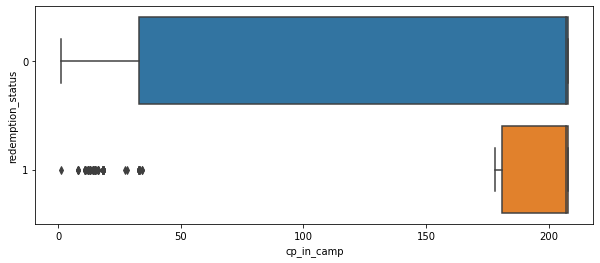

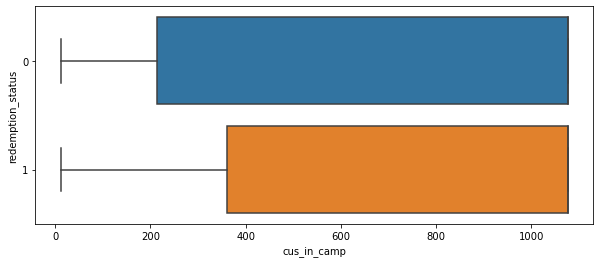

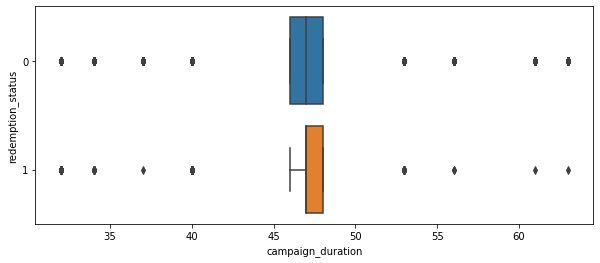

In [129]:
def plot_numerical(df, feature):
    figure(figsize=(10, 4))
    sns.boxplot(x=f, y="redemption_status", data=df, orient='h')
    plt.show()
    
for f in num_features:
    plot_numerical(train_raw, f)

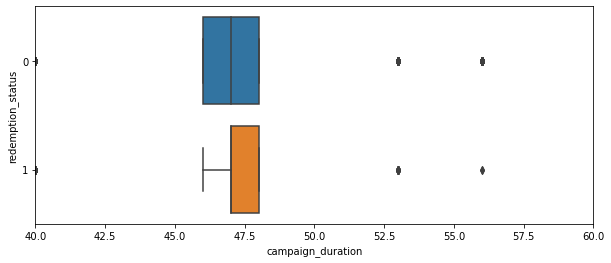

In [130]:
figure(figsize=(10, 4))
sns.boxplot(x="campaign_duration", y="redemption_status", data=train_raw, orient='h')
plt.xlim(40, 60)
plt.show()

- cp_in_camp: Does not appear to have different means between the two redemption status.
- cus_in_camp: Does not appear to have different means between the two redemption status.
- campaign_duration: longer duration seems to increase redemption.

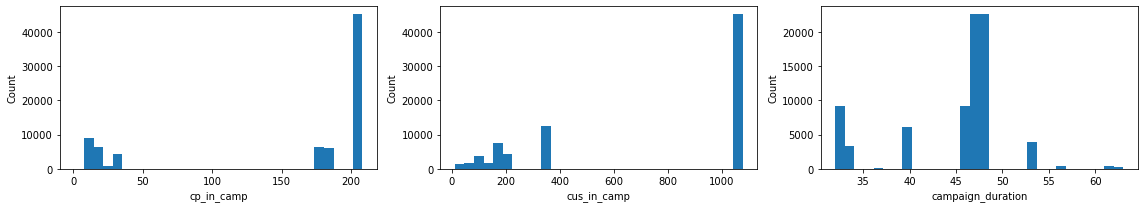

In [131]:
# The numerical features are obviously not Gaussian distributed.
# Therefore, statistical testing such as t-test is not appropriate.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 3))
for i in range(3):
    axes[i].hist(train_raw[num_features[i]], bins=30)
    axes[i].set_xlabel(num_features[i])
    axes[i].set_ylabel('Count')

fig.tight_layout()

## Transaction features

In [132]:
train_raw_trans.head()

id  campaign_id  coupon_id  customer_id  redemption_status  \
0   1           13         27         1053                  0   
1   2           13        116           48                  0   
2   6            9        635          205                  0   
3   7           13        644         1050                  0   
4   9            8       1017         1489                  0   

   avg_coupon_discount  avg_other_discount   avg_sales  \
0             0.287258           33.168935  184.260484   
1             3.215039           27.699169  234.247013   
2             2.212082           17.795660  121.094495   
3             0.751477           16.655570   98.276034   
4             0.471548           20.524733  120.636103   

   avg_use_coupon_discount  avg_use_other_discount  monthly_cp_disc  \
0                 0.003226                0.538710         4.947222   
1                 0.031169                0.542857        77.361875   
2                 0.087629                0.471134       134.107500   
3                 0.008439                0.506329        10.476471   
4                 0.017794                0.500000        17.667333   

   monthly_ct_trans  monthly_other_disc  monthly_sales  monthly_freq_cp_disc  \
0         16.888889          564.277222    3107.577222              0.055556   
1         24.062500          666.511250    5636.568750              0.750000   
2         60.625000         1078.861875    7341.353750              5.312500   
3         13.941176          232.198235    1370.083529              0.117647   
4         37.133333          762.700000    4489.698000              0.666667   

   monthly_freq_other_disc  cus_Established  cus_Alcohol  cus_Bakery  \
0                 9.166667         0.535484     0.000000    0.000000   
1                13.062500         0.755844     0.000000    0.025974   
2                28.562500         0.814433     0.000000    0.008247   
3                 7.058824         0.531646     0.004219    0.042194   
4                18.533333         0.713523     0.000000    0.008897   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000                   0.0  0.048387         0.0   
1                    0.002597                   0.0  0.002597         0.0   
2                    0.007216                   0.0  0.000000         0.0   
3                    0.000000                   0.0  0.000000         0.0   
4                    0.000000                   0.0  0.024911         0.0   

   cus_Grocery  cus_Meat  cus_Miscellaneous  cus_Natural Products  \
0     0.690323  0.061290           0.000000              0.022581   
1     0.618182  0.033766           0.007792              0.054545   
2     0.731959  0.064948           0.001031              0.052577   
3     0.780591  0.000000           0.000000              0.004219   
4     0.718861  0.019573           0.021352              0.017794   

   cus_Packaged Meat  cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  \
0           0.093548            0.067742           0.003226              0.0   
1           0.080519            0.148052           0.010390              0.0   
2           0.022680            0.088660           0.017526              0.0   
3           0.037975            0.113924           0.012658              0.0   
4           0.103203            0.085409           0.000000              0.0   

   cus_Salads  cus_Seafood  cus_Skin & Hair Care  cus_Travel  \
0    0.000000     0.012903              0.000000         0.0   
1    0.002597     0.012987              0.000000         0.0   
2    0.000000     0.001031              0.004124         0.0   
3    0.000000     0.000000              0.004219         0.0   
4    0.000000     0.000000              0.000000         0.0   

   cus_Vegetables (cut)  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [133]:
train_raw_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          78369 non-null  int64  
 1   campaign_id                 78369 non-null  int64  
 2   coupon_id                   78369 non-null  int64  
 3   customer_id                 78369 non-null  int64  
 4   redemption_status           78369 non-null  int64  
 5   avg_coupon_discount         78369 non-null  float64
 6   avg_other_discount          78369 non-null  float64
 7   avg_sales                   78369 non-null  float64
 8   avg_use_coupon_discount     78369 non-null  float64
 9   avg_use_other_discount      78369 non-null  float64
 10  monthly_cp_disc             78369 non-null  float64
 11  monthly_ct_trans            78369 non-null  float64
 12  monthly_other_disc          78369 non-null  float64
 13  monthly_sales               783

All features in train_raw_trans are numerical or can be easily converted to numerical values. Therefore, Pearson correlation coefficients can be calculated between feature pairs to identify highly correlated features followed by removal.

In [134]:
def strongCorr(df, limit):
    correlation_matrix = df.corr()
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):   # range(i)  -> This is bottom right triangle w/o diag line
            if abs(correlation_matrix.iloc[i, j]) > limit:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return correlated_features

In [135]:
correlated_features = strongCorr(train_raw_trans.iloc[:,5:], 0.7)
correlated_features

{'avg_use_coupon_discount',
 'monthly_cp_disc',
 'monthly_freq_cp_disc',
 'monthly_freq_other_disc',
 'monthly_other_disc',
 'monthly_sales'}

In [136]:
# VIF method may be better because it detects multicollinearity, not just pairwise collinearity

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i)\
                  for i in range(X.shape[1])]
    return vif

In [137]:
%%time

del_variables = []

while True:
    
    vif = calc_vif(train_raw_trans.iloc[:,5:])
    vif.sort_values('VIF', axis=0, ascending=False, inplace=True)
    print('Top two VIF variables:\n', vif.head(2))
    
    if vif.VIF.max()<7:
        break
    else:    
        #del_var = vif[vif.VIF == vif.VIF.max()].iloc[0,0]
        del_var = vif.iloc[0,0]
        print('variable to delete: ', del_var, '\n')
        del_variables.append(del_var)
        train_raw_trans.drop(columns=[del_var], inplace=True)

print('\nDeleted variables: ', del_variables)

Top two VIF variables:
            variables         VIF
18       cus_Grocery  155.876164
6   monthly_ct_trans   64.113459
variable to delete:  cus_Grocery 

Top two VIF variables:
                   variables         VIF
6          monthly_ct_trans  127.723641
10  monthly_freq_other_disc  102.642741
variable to delete:  monthly_ct_trans 

Top two VIF variables:
                  variables        VIF
4   avg_use_other_discount  61.501585
9  monthly_freq_other_disc  60.433566
variable to delete:  avg_use_other_discount 

Top two VIF variables:
          variables        VIF
4  monthly_cp_disc  52.967482
2        avg_sales  50.526555
variable to delete:  monthly_cp_disc 

Top two VIF variables:
             variables        VIF
2           avg_sales  49.817013
4  monthly_other_disc  41.512067
variable to delete:  avg_sales 

Top two VIF variables:
                  variables        VIF
3       monthly_other_disc  40.347953
6  monthly_freq_other_disc  29.359284
variable to delete:  monthl

In [138]:
def dropFeature(df, removed_cols):
      return df.drop(removed_cols, axis=1)

In [139]:
# train_raw_trans = dropFeature(train_raw_trans, correlated_features)
# train_raw_trans.head()

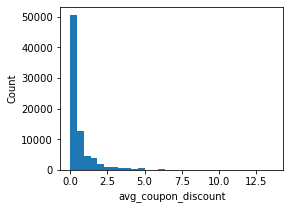

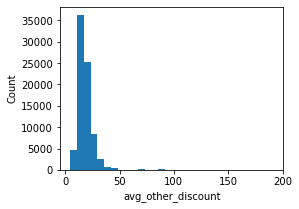

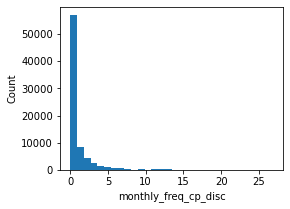

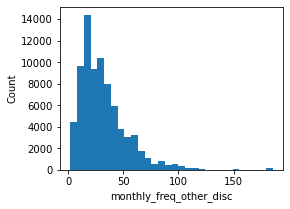

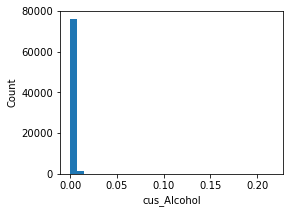

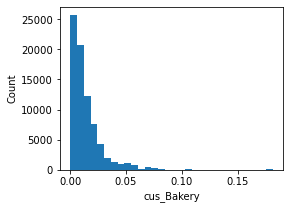

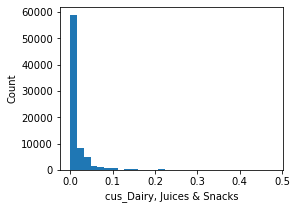

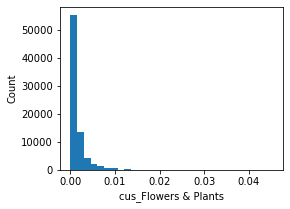

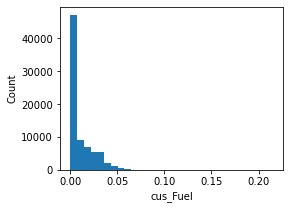

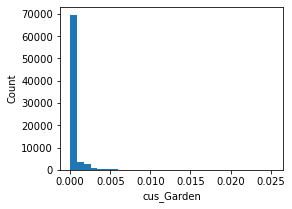

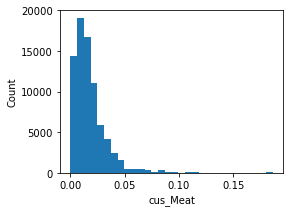

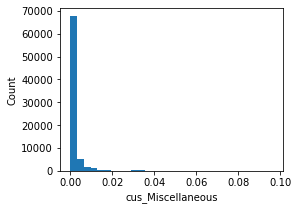

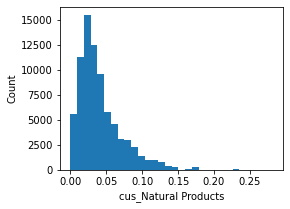

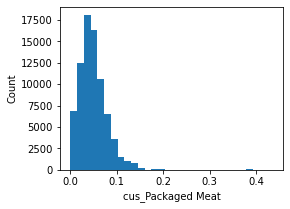

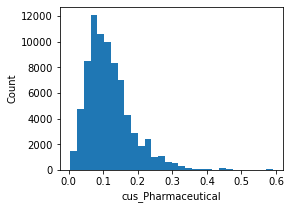

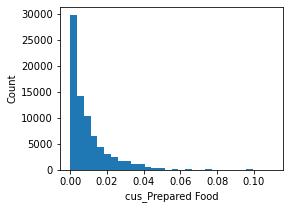

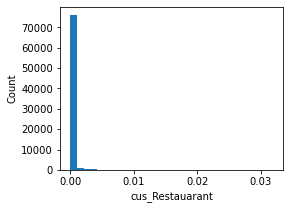

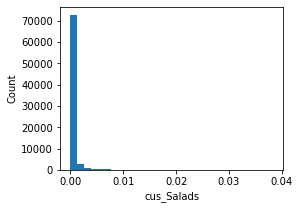

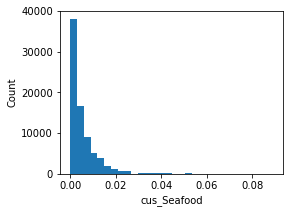

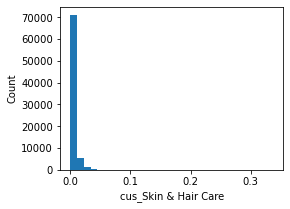

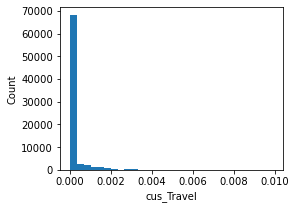

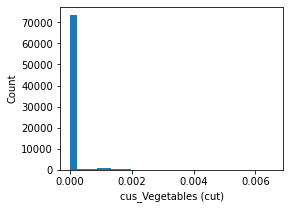

In [140]:
def plot_num_distr(df, feature):
    fig, axes = plt.subplots(figsize=(4, 3))
    plt.hist(df[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

trans_features = train_raw_trans.iloc[:,5:].columns    
    
    
for f in trans_features:
    plot_num_distr(train_raw_trans, f)

From the figures above, some of the transaction features exhibit near-normal distribution, while others are heavily skewed (left or right).

For the features with near-normal distribution, we can perform ANOVA tests to examine their correlation with the target variable. Other features may not.

Considering that the number of transaction features is not small (27), I skipped examining feature-target variable correlation. Instead, I will use feature importance after initial model building to inform feature downselection.

## Semi-final train dataset

Obtain train_final by:
- encoding categorical features
- selecting numerical features
- combining all categorical features and numerical features

In [141]:
train_raw.head()

id  campaign_id  coupon_id  customer_id  redemption_status  cp_in_camp  \
0   1           13         27         1053                  0         207   
1   2           13        116           48                  0         207   
2   6            9        635          205                  0          18   
3   7           13        644         1050                  0         207   
4   9            8       1017         1489                  0         208   

   cus_in_camp campaign_type start_date   end_date  campaign_duration  \
0         1077             X 2013-05-19 2013-07-05                 47   
1         1077             X 2013-05-19 2013-07-05                 47   
2          176             Y 2013-03-11 2013-04-12                 32   
3         1077             X 2013-05-19 2013-07-05                 47   
4         1076             X 2013-02-16 2013-04-05                 48   

   ct_brand  ct_category      brand        category   brand_type  \
0         1            0  multipleb         Grocery  Established   
1         0            0        56b         Grocery        Local   
2         0            0       560b  Pharmaceutical  Established   
3         0            0       611b         Grocery  Established   
4         0            0      1558b         Grocery  Established   

  num_it_in_cp_bin age_range   rented       family_size  income_bracket  
0      (100, 1000]     46-55       No        fam_size_1        income_5  
1           (0, 5]     36-45       No        fam_size_2        income_3  
2        (50, 100]     46-55       No        fam_size_2        income_7  
3           (0, 5]   unknown  unknown  fam_size_unknown  income_unknown  
4         (10, 50]     46-55       No        fam_size_2        income_3

In [142]:
# Does any feature have single value? - No
train_single_val = []
for i in train_raw.columns:
    if len(train_raw[i].unique())==1:
        train_single_val.append(i)
print('Features in train_raw that only has one value\n',
      train_single_val)

Features in train_raw that only has one value
 []


In [143]:
cat_features

# except for brand, all categorical features can be dummy or one-hot encoded
# brand: base N encoding due to large number of levels

['campaign_type',
 'ct_brand',
 'ct_category',
 'brand',
 'category',
 'brand_type',
 'num_it_in_cp_bin',
 'age_range',
 'rented',
 'family_size',
 'income_bracket']

In [144]:
features_NoE = ['ct_brand', 'ct_category']
features_BNE = ['brand']
features_OHE = list(set(cat_features)-set(features_NoE)-set(features_BNE))

In [145]:
num_features

['cp_in_camp', 'cus_in_camp', 'campaign_duration']

In [146]:
OH_encoder = OneHotEncoder(handle_unknown='ignore')
df_OHE = OH_encoder.fit_transform(train_raw[features_OHE])
cols_new = OH_encoder.get_feature_names(features_OHE)

df_OHE =  pd.DataFrame(df_OHE.todense(), columns=cols_new)
df_OHE.head()

campaign_type_X  campaign_type_Y  brand_type_Established  brand_type_Local  \
0              1.0              0.0                     1.0               0.0   
1              1.0              0.0                     0.0               1.0   
2              0.0              1.0                     1.0               0.0   
3              1.0              0.0                     1.0               0.0   
4              1.0              0.0                     1.0               0.0   

   brand_type_multiple  family_size_fam_size_1  family_size_fam_size_2  \
0                  0.0                     1.0                     0.0   
1                  0.0                     0.0                     1.0   
2                  0.0                     0.0                     1.0   
3                  0.0                     0.0                     0.0   
4                  0.0                     0.0                     1.0   

   family_size_fam_size_3  family_size_fam_size_4  family_size_fam_size_5+  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     0.0                      0.0   

   family_size_fam_size_unknown  rented_No  rented_Yes  rented_unknown  \
0                           0.0        1.0         0.0             0.0   
1                           0.0        1.0         0.0             0.0   
2                           0.0        1.0         0.0             0.0   
3                           1.0        0.0         0.0             1.0   
4                           0.0        1.0         0.0             0.0   

   num_it_in_cp_bin_(0, 5]  num_it_in_cp_bin_(10, 50]  \
0                      0.0                        0.0   
1                      1.0                        0.0   
2                      0.0                        0.0   
3                      1.0                        0.0   
4                      0.0                        1.0   

   num_it_in_cp_bin_(100, 1000]  num_it_in_cp_bin_(1000, 12000]  \
0                           1.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   num_it_in_cp_bin_(5, 10]  num_it_in_cp_bin_(50, 100]  category_Bakery  \
0                       0.0                         0.0              0.0   
1                       0.0                         0.0              0.0   
2                       0.0                         1.0              0.0   
3                       0.0                         0.0              0.0   
4                       0.0                         0.0              0.0   

   category_Dairy, Juices & Snacks  category_Flowers & Plants  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              0.0                        0.0   
4                              0.0                        0.0   

   category_Grocery  category_Meat  category_Natural Products  \
0               1.0            0.0                        0.0   
1               1.0            0.0                        0.0   
2               0.0            0.0                        0.0   
3               1.0            0.0                        0.0   
4               1.0            0.0                        0.0   

   category_Packaged Meat  category_Pharmaceutical  category_Prepared Food  \
0                     0.0                      0.0                     0.0   
1               

In [147]:
import category_encoders as ce

BN_encoder = ce.BaseNEncoder(base=5)
df_BNE = BN_encoder.fit_transform(train_raw[features_BNE])
df_BNE.head()

brand_0  brand_1  brand_2  brand_3  brand_4
0        0        0        0        0        1
1        0        0        0        0        2
2        0        0        0        0        3
3        0        0        0        0        4
4        0        0        0        1        0

In [148]:
train_raw_trans.head()

id  campaign_id  coupon_id  customer_id  redemption_status  \
0   1           13         27         1053                  0   
1   2           13        116           48                  0   
2   6            9        635          205                  0   
3   7           13        644         1050                  0   
4   9            8       1017         1489                  0   

   avg_coupon_discount  avg_other_discount  monthly_freq_cp_disc  \
0             0.287258           33.168935              0.055556   
1             3.215039           27.699169              0.750000   
2             2.212082           17.795660              5.312500   
3             0.751477           16.655570              0.117647   
4             0.471548           20.524733              0.666667   

   monthly_freq_other_disc  cus_Alcohol  cus_Bakery  \
0                 9.166667     0.000000    0.000000   
1                13.062500     0.000000    0.025974   
2                28.562500     0.000000    0.008247   
3                 7.058824     0.004219    0.042194   
4                18.533333     0.000000    0.008897   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000                   0.0  0.048387         0.0   
1                    0.002597                   0.0  0.002597         0.0   
2                    0.007216                   0.0  0.000000         0.0   
3                    0.000000                   0.0  0.000000         0.0   
4                    0.000000                   0.0  0.024911         0.0   

   cus_Meat  cus_Miscellaneous  cus_Natural Products  cus_Packaged Meat  \
0  0.061290           0.000000              0.022581           0.093548   
1  0.033766           0.007792              0.054545           0.080519   
2  0.064948           0.001031              0.052577           0.022680   
3  0.000000           0.000000              0.004219           0.037975   
4  0.019573           0.021352              0.017794           0.103203   

   cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  cus_Salads  \
0            0.067742           0.003226              0.0    0.000000   
1            0.148052           0.010390              0.0    0.002597   
2            0.088660           0.017526              0.0    0.000000   
3            0.113924           0.012658              0.0    0.000000   
4            0.085409           0.000000              0.0    0.000000   

   cus_Seafood  cus_Skin & Hair Care  cus_Travel  cus_Vegetables (cut)  
0     0.012903              0.000000         0.0                   0.0  
1     0.012987              0.000000         0.0                   0.0  
2     0.001031              0.004124         0.0                   0.0  
3     0.000000              0.004219         0.0                   0.0  
4     0.000000              0.000000         0.0                   0.0

In [149]:
dfs = [train_raw_trans, train_raw[features_NoE],\
       df_OHE, df_BNE, train_raw[num_features]]

train_final_X = dfs[0]

for df in dfs[1:]:
    train_final_X = train_final_X.join(df)

train_final_X.head()

id  campaign_id  coupon_id  customer_id  redemption_status  \
0   1           13         27         1053                  0   
1   2           13        116           48                  0   
2   6            9        635          205                  0   
3   7           13        644         1050                  0   
4   9            8       1017         1489                  0   

   avg_coupon_discount  avg_other_discount  monthly_freq_cp_disc  \
0             0.287258           33.168935              0.055556   
1             3.215039           27.699169              0.750000   
2             2.212082           17.795660              5.312500   
3             0.751477           16.655570              0.117647   
4             0.471548           20.524733              0.666667   

   monthly_freq_other_disc  cus_Alcohol  cus_Bakery  \
0                 9.166667     0.000000    0.000000   
1                13.062500     0.000000    0.025974   
2                28.562500     0.000000    0.008247   
3                 7.058824     0.004219    0.042194   
4                18.533333     0.000000    0.008897   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000                   0.0  0.048387         0.0   
1                    0.002597                   0.0  0.002597         0.0   
2                    0.007216                   0.0  0.000000         0.0   
3                    0.000000                   0.0  0.000000         0.0   
4                    0.000000                   0.0  0.024911         0.0   

   cus_Meat  cus_Miscellaneous  cus_Natural Products  cus_Packaged Meat  \
0  0.061290           0.000000              0.022581           0.093548   
1  0.033766           0.007792              0.054545           0.080519   
2  0.064948           0.001031              0.052577           0.022680   
3  0.000000           0.000000              0.004219           0.037975   
4  0.019573           0.021352              0.017794           0.103203   

   cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  cus_Salads  \
0            0.067742           0.003226              0.0    0.000000   
1            0.148052           0.010390              0.0    0.002597   
2            0.088660           0.017526              0.0    0.000000   
3            0.113924           0.012658              0.0    0.000000   
4            0.085409           0.000000              0.0    0.000000   

   cus_Seafood  cus_Skin & Hair Care  cus_Travel  cus_Vegetables (cut)  \
0     0.012903              0.000000         0.0                   0.0   
1     0.012987              0.000000         0.0                   0.0   
2     0.001031              0.004124         0.0                   0.0   
3     0.000000              0.004219         0.0                   0.0   
4     0.000000              0.000000         0.0                   0.0   

   ct_brand  ct_category  campaign_type_X  campaign_type_Y  \
0         1            0              1.0              0.0   
1         0            0              1.0              0.0   
2         0            0              0.0              1.0   
3         0            0              1.0              0.0   
4         0            0              1.0              0.0   

   brand_type_Established  brand_type_Local  brand_type_multiple  \
0                     1.0               0.0                  0.0   
1                     0.0               1.0                  0.0   
2                     1.0               0.0                  0.0   
3                     1.0               0.0                  0.0   
4                     1.0               0.0                  0.0   

   family_size_fam_size_1  family_size_fam_size_2  family_size_fam_size_3  \
0                     1.0                     0.0                     0.0   
1                     0.0                     1.0                     0.0   
2                     0.0                     1.0            

In [150]:
train_final_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 89 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               78369 non-null  int64  
 1   campaign_id                      78369 non-null  int64  
 2   coupon_id                        78369 non-null  int64  
 3   customer_id                      78369 non-null  int64  
 4   redemption_status                78369 non-null  int64  
 5   avg_coupon_discount              78369 non-null  float64
 6   avg_other_discount               78369 non-null  float64
 7   monthly_freq_cp_disc             78369 non-null  float64
 8   monthly_freq_other_disc          78369 non-null  float64
 9   cus_Alcohol                      78369 non-null  float64
 10  cus_Bakery                       78369 non-null  float64
 11  cus_Dairy, Juices & Snacks       78369 non-null  float64
 12  cus_Flowers & Plan

## Semi-final test dataset

In [151]:
test_raw = pd.merge(test, cp_in_camp_df, on='campaign_id', how='left') 
test_raw = pd.merge(test_raw, cus_in_camp_df, on='campaign_id', how='left') 
test_raw = pd.merge(test_raw, campaign, on='campaign_id', how='left') 
test_raw = pd.merge(test_raw, coupon_item_sub1, on='coupon_id', how='left')
test_raw = pd.merge(test_raw, demog, on='customer_id', how='left')
test_raw.drop(columns=['marital_status','no_of_children'], inplace=True)
test_raw.fillna('unknown', inplace=True)

test_raw['brand'] = test_raw['brand'].map(lambda x: str(x)+'b')
test_raw['rented'] = test_raw['rented'].map(lambda x:
                                              'No' if x==0.0 else
                                              ('Yes' if x==1.0 else x))
test_raw['family_size'] =\
    test_raw['family_size'].map(lambda x: 'fam_size_'+str(x))
test_raw['income_bracket'] =\
    test_raw['income_bracket'].map(lambda x:
                                    'income_'+str(x)[:-2] if '.' in str(x)
                                    else 'income_'+str(x))

test_raw.num_it_in_cp_bin = \
    test_raw.num_it_in_cp_bin.map(lambda x: str(x))

test_raw.head()

id  campaign_id  coupon_id  customer_id cp_in_camp cus_in_camp  \
0   3           22        869          967    unknown     unknown   
1   4           20        389         1566    unknown     unknown   
2   5           22        981          510    unknown     unknown   
3   8           25       1069          361    unknown     unknown   
4  10           17        498          811    unknown     unknown   

  campaign_type start_date   end_date  campaign_duration  ct_brand  \
0             X 2013-09-16 2013-10-18                 32         0   
1             Y 2013-09-07 2013-11-16                 70         1   
2             X 2013-09-16 2013-10-18                 32         0   
3             Y 2013-10-21 2013-11-22                 32         0   
4             Y 2013-07-29 2013-08-30                 32         0   

   ct_category      brand        category   brand_type num_it_in_cp_bin  \
0            0      1075b         Grocery  Established        (50, 100]   
1            0  multipleb  Pharmaceutical  Established         (10, 50]   
2            0      1335b         Grocery  Established         (10, 50]   
3            0      1996b         Grocery  Established        (50, 100]   
4            0       209b         Grocery  Established         (10, 50]   

  age_range   rented       family_size  income_bracket  
0     36-45       No        fam_size_1        income_5  
1     26-35       No        fam_size_2        income_9  
2     26-35       No        fam_size_2        income_1  
3     18-25       No        fam_size_1        income_3  
4   unknown  unknown  fam_size_unknown  income_unknown

In [152]:
test_raw_trans = pd.merge(test, transaction_customer_avg, on='customer_id', how='left')
test_raw_trans = pd.merge(test_raw_trans, customer_trans, on='customer_id', how='left')
test_raw_trans = pd.merge(test_raw_trans, customer_item, on='customer_id', how='left')
test_raw_trans.head()

test_raw_trans = dropFeature(test_raw_trans, del_variables)
test_raw_trans.head()

id  campaign_id  coupon_id  customer_id  avg_coupon_discount  \
0   3           22        869          967             1.550558   
1   4           20        389         1566             0.559929   
2   5           22        981          510             1.452345   
3   8           25       1069          361             0.000000   
4  10           17        498          811             0.067506   

   avg_other_discount  monthly_freq_cp_disc  monthly_freq_other_disc  \
0           11.962548              5.400000                40.200000   
1           12.311514              2.066667                75.133333   
2           24.025816              3.500000                55.625000   
3           13.448429              0.000000                14.764706   
4           14.567104              0.200000                39.600000   

   cus_Alcohol  cus_Bakery  cus_Dairy, Juices & Snacks  cus_Flowers & Plants  \
0     0.000734    0.011747                    0.000734              0.000000   
1     0.000000    0.004510                    0.002631              0.000752   
2     0.000000    0.004263                    0.001218              0.000000   
3     0.000000    0.010471                    0.000000              0.000000   
4     0.000000    0.003791                    0.004549              0.000000   

   cus_Fuel  cus_Garden  cus_Meat  cus_Miscellaneous  cus_Natural Products  \
0  0.000734         0.0  0.006608           0.002937              0.036711   
1  0.007516         0.0  0.007140           0.001503              0.028936   
2  0.023143         0.0  0.017052           0.000000              0.012180   
3  0.010471         0.0  0.029668           0.001745              0.045375   
4  0.000000         0.0  0.049280           0.000000              0.037908   

   cus_Packaged Meat  cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  \
0           0.064611            0.130690           0.014684         0.000000   
1           0.018414            0.233747           0.007140         0.000376   
2           0.078563            0.104750           0.003045         0.000000   
3           0.033159            0.076789           0.000000         0.000000   
4           0.070508            0.063685           0.000758         0.000000   

   cus_Salads  cus_Seafood  cus_Skin & Hair Care  cus_Travel  \
0         0.0     0.002203              0.008076    0.000000   
1         0.0     0.000376              0.000752    0.000752   
2         0.0     0.002436              0.000000    0.000609   
3         0.0     0.000000              0.000000    0.000000   
4         0.0     0.012889              0.002274    0.000758   

   cus_Vegetables (cut)  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [153]:
df_OHE = OH_encoder.transform(test_raw[features_OHE])
df_OHE = pd.DataFrame(df_OHE.todense(), columns=cols_new)

df_BNE = BN_encoder.transform(test_raw[features_BNE])


dfs = [test_raw_trans, test_raw[features_NoE],\
       df_OHE, df_BNE, test_raw[num_features],]

test_final_X = dfs[0]

for df in dfs[1:]:
    test_final_X = test_final_X.join(df)

test_final_X.head()

id  campaign_id  coupon_id  customer_id  avg_coupon_discount  \
0   3           22        869          967             1.550558   
1   4           20        389         1566             0.559929   
2   5           22        981          510             1.452345   
3   8           25       1069          361             0.000000   
4  10           17        498          811             0.067506   

   avg_other_discount  monthly_freq_cp_disc  monthly_freq_other_disc  \
0           11.962548              5.400000                40.200000   
1           12.311514              2.066667                75.133333   
2           24.025816              3.500000                55.625000   
3           13.448429              0.000000                14.764706   
4           14.567104              0.200000                39.600000   

   cus_Alcohol  cus_Bakery  cus_Dairy, Juices & Snacks  cus_Flowers & Plants  \
0     0.000734    0.011747                    0.000734              0.000000   
1     0.000000    0.004510                    0.002631              0.000752   
2     0.000000    0.004263                    0.001218              0.000000   
3     0.000000    0.010471                    0.000000              0.000000   
4     0.000000    0.003791                    0.004549              0.000000   

   cus_Fuel  cus_Garden  cus_Meat  cus_Miscellaneous  cus_Natural Products  \
0  0.000734         0.0  0.006608           0.002937              0.036711   
1  0.007516         0.0  0.007140           0.001503              0.028936   
2  0.023143         0.0  0.017052           0.000000              0.012180   
3  0.010471         0.0  0.029668           0.001745              0.045375   
4  0.000000         0.0  0.049280           0.000000              0.037908   

   cus_Packaged Meat  cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  \
0           0.064611            0.130690           0.014684         0.000000   
1           0.018414            0.233747           0.007140         0.000376   
2           0.078563            0.104750           0.003045         0.000000   
3           0.033159            0.076789           0.000000         0.000000   
4           0.070508            0.063685           0.000758         0.000000   

   cus_Salads  cus_Seafood  cus_Skin & Hair Care  cus_Travel  \
0         0.0     0.002203              0.008076    0.000000   
1         0.0     0.000376              0.000752    0.000752   
2         0.0     0.002436              0.000000    0.000609   
3         0.0     0.000000              0.000000    0.000000   
4         0.0     0.012889              0.002274    0.000758   

   cus_Vegetables (cut)  ct_brand  ct_category  campaign_type_X  \
0                   0.0         0            0              1.0   
1                   0.0         1            0              0.0   
2                   0.0         0            0              1.0   
3                   0.0         0            0              0.0   
4                   0.0         0            0              0.0   

   campaign_type_Y  brand_type_Established  brand_type_Local  \
0              0.0                     1.0               0.0   
1              1.0                     1.0               0.0   
2              0.0                     1.0               0.0   
3              1.0                     1.0               0.0   
4              1.0                     1.0               0.0   

   brand_type_multiple  family_size_fam_size_1  family_size_fam_size_2  \
0                  0.0                     1.0                     0.0   
1                  0.0                     0.0                     1.0   
2                  0.0                     0.0                     1.0   
3                  0.0                     1.0                     0.0   
4                  0.0                     0.0                     0.0   

   family_size_fam_size_3  family_size_fam_size_4  family_size_fam_size_5+  \
0                     0.0               

In [154]:
test_final_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50226 entries, 0 to 50225
Data columns (total 88 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               50226 non-null  int64  
 1   campaign_id                      50226 non-null  int64  
 2   coupon_id                        50226 non-null  int64  
 3   customer_id                      50226 non-null  int64  
 4   avg_coupon_discount              50226 non-null  float64
 5   avg_other_discount               50226 non-null  float64
 6   monthly_freq_cp_disc             50226 non-null  float64
 7   monthly_freq_other_disc          50226 non-null  float64
 8   cus_Alcohol                      50226 non-null  float64
 9   cus_Bakery                       50226 non-null  float64
 10  cus_Dairy, Juices & Snacks       50226 non-null  float64
 11  cus_Flowers & Plants             50226 non-null  float64
 12  cus_Fuel          

In [155]:
# Does any feature have single value? - Yes
test_single_val = []
for i in test_final_X.columns:
    if len(test_final_X[i].unique())==1:
        test_single_val.append(i)
print('Features in test_final_X that only has one value\n',
      test_single_val)

Features in test_final_X that only has one value
 ['brand_0', 'cp_in_camp', 'cus_in_camp']


## Final datasets

In [156]:
features_single_val = list(set(train_single_val+test_single_val))
features_single_val

train_final_X.drop(columns=features_single_val, inplace=True)
test_final_X.drop(columns=features_single_val, inplace=True)

### Merge with external features

In [157]:
# 20210706 merge data with Helen's

helen_train = pd.read_csv('helen_train_trans.csv')
helen_test = pd.read_csv('helen_test_trans.csv')

In [158]:
#helen_train.head()

In [159]:
#helen_test.head()

In [160]:
train_final_X_merged = train_final_X.merge(helen_train, on='id', how='left')
test_final_X_merged = test_final_X.merge(helen_test, on='id', how='left')

In [161]:
#cost_saved_coupon, cost_saved_total, change to positive values
flip_sign_f = ['cost_saved_coupon', 'cost_saved_total']

for i in flip_sign_f:
    train_final_X_merged[i] = train_final_X_merged[i].map(lambda x: -1*x if x<0.0 else x)
    test_final_X_merged[i] = test_final_X_merged[i].map(lambda x: -1*x if x<0.0 else x)

In [162]:
#train_final_X_merged.to_csv(r'.\train_merged.csv')
#test_final_X_merged.to_csv(r'.\test_merged.csv')

In [163]:
# train_raw_merged = train_raw.merge(
#     train_raw_trans.drop(columns=['campaign_id','coupon_id','customer_id','redemption_status']),
#     on='id', how='left')
# train_raw_merged = train_raw_merged.merge(helen_train, on='id', how='left')
# train_raw_merged.info()

In [164]:
# test_raw_merged = test_raw.merge(
#     test_raw_trans.drop(columns=['campaign_id','coupon_id','customer_id']),
#     on='id', how='left')
# test_raw_merged = test_raw_merged.merge(helen_test, on='id', how='left')
# test_raw_merged.info()

In [165]:
#train_raw_merged.to_csv(r'.\train_merged_before_encoding.csv')
#test_raw_merged.to_csv(r'.\test_merged_before_encoding.csv')

# Modeling

## Remove multicollinearity

In [166]:
# Only numerical features

helen_num_features = ['trans_count', 'cust_duration_month',
                      'month_trans_ave', 'coupon_use_rate',
                      'cost_saved_coupon', 'cost_saved_total', 'money_spent' ]

total_num_features = ['campaign_duration']\
    + list(np.array(train_raw_trans.drop(columns=
         ['id','campaign_id','coupon_id','customer_id','redemption_status']).columns))\
    + helen_num_features
total_num_features

['campaign_duration',
 'avg_coupon_discount',
 'avg_other_discount',
 'monthly_freq_cp_disc',
 'monthly_freq_other_disc',
 'cus_Alcohol',
 'cus_Bakery',
 'cus_Dairy, Juices & Snacks',
 'cus_Flowers & Plants',
 'cus_Fuel',
 'cus_Garden',
 'cus_Meat',
 'cus_Miscellaneous',
 'cus_Natural Products',
 'cus_Packaged Meat',
 'cus_Pharmaceutical',
 'cus_Prepared Food',
 'cus_Restauarant',
 'cus_Salads',
 'cus_Seafood',
 'cus_Skin & Hair Care',
 'cus_Travel',
 'cus_Vegetables (cut)',
 'trans_count',
 'cust_duration_month',
 'month_trans_ave',
 'coupon_use_rate',
 'cost_saved_coupon',
 'cost_saved_total',
 'money_spent']

In [167]:
correlated_features2 = strongCorr(train_final_X_merged[total_num_features], 0.8)
correlated_features2

{'cost_saved_coupon',
 'cost_saved_total',
 'coupon_use_rate',
 'money_spent',
 'month_trans_ave',
 'trans_count'}

In [168]:
%%time

del_variables = []

while True:
    
    vif = calc_vif(train_final_X_merged[total_num_features])
    vif.sort_values('VIF', axis=0, ascending=False, inplace=True)
    print('Top two VIF variables:\n', vif.head(2))
    
    if vif.VIF.max()<7:
        break
    else:    
        #del_var = vif[vif.VIF == vif.VIF.max()].iloc[0,0]
        del_var = vif.iloc[0,0]
        print('variable to delete: ', del_var, '\n')
        total_num_features.remove(del_var)
        del_variables.append(del_var)
        train_final_X_merged.drop(columns=[del_var], inplace=True)

print('\nDeleted variables: ', del_variables)
print('\nRemaining numerical features: ', total_num_features)

Top two VIF variables:
           variables         VIF
23      trans_count  113.150314
25  month_trans_ave   85.758233
variable to delete:  trans_count 

Top two VIF variables:
             variables        VIF
24    month_trans_ave  50.953370
0   campaign_duration  35.420814
variable to delete:  month_trans_ave 

Top two VIF variables:
             variables        VIF
0   campaign_duration  32.051355
26   cost_saved_total  23.113368
variable to delete:  campaign_duration 

Top two VIF variables:
               variables        VIF
25     cost_saved_total  20.767511
22  cust_duration_month  13.561902
variable to delete:  cost_saved_total 

Top two VIF variables:
               variables        VIF
22  cust_duration_month  13.355428
0   avg_coupon_discount   9.388142
variable to delete:  cust_duration_month 

Top two VIF variables:
               variables       VIF
0   avg_coupon_discount  9.051862
22      coupon_use_rate  8.801317
variable to delete:  avg_coupon_discount 

Top two V

In [169]:
train_final_X_merged.head()

id  campaign_id  coupon_id  customer_id  redemption_status  \
0   1           13         27         1053                  0   
1   2           13        116           48                  0   
2   6            9        635          205                  0   
3   7           13        644         1050                  0   
4   9            8       1017         1489                  0   

   avg_other_discount  monthly_freq_cp_disc  cus_Alcohol  cus_Bakery  \
0           33.168935              0.055556     0.000000    0.000000   
1           27.699169              0.750000     0.000000    0.025974   
2           17.795660              5.312500     0.000000    0.008247   
3           16.655570              0.117647     0.004219    0.042194   
4           20.524733              0.666667     0.000000    0.008897   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000                   0.0  0.048387         0.0   
1                    0.002597                   0.0  0.002597         0.0   
2                    0.007216                   0.0  0.000000         0.0   
3                    0.000000                   0.0  0.000000         0.0   
4                    0.000000                   0.0  0.024911         0.0   

   cus_Meat  cus_Miscellaneous  cus_Natural Products  cus_Packaged Meat  \
0  0.061290           0.000000              0.022581           0.093548   
1  0.033766           0.007792              0.054545           0.080519   
2  0.064948           0.001031              0.052577           0.022680   
3  0.000000           0.000000              0.004219           0.037975   
4  0.019573           0.021352              0.017794           0.103203   

   cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  cus_Salads  \
0            0.067742           0.003226              0.0    0.000000   
1            0.148052           0.010390              0.0    0.002597   
2            0.088660           0.017526              0.0    0.000000   
3            0.113924           0.012658              0.0    0.000000   
4            0.085409           0.000000              0.0    0.000000   

   cus_Seafood  cus_Skin & Hair Care  cus_Travel  cus_Vegetables (cut)  \
0     0.012903              0.000000         0.0                   0.0   
1     0.012987              0.000000         0.0                   0.0   
2     0.001031              0.004124         0.0                   0.0   
3     0.000000              0.004219         0.0                   0.0   
4     0.000000              0.000000         0.0                   0.0   

   ct_brand  ct_category  campaign_type_X  campaign_type_Y  \
0         1            0              1.0              0.0   
1         0            0              1.0              0.0   
2         0            0              0.0              1.0   
3         0            0              1.0              0.0   
4         0            0              1.0              0.0   

   brand_type_Established  brand_type_Local  brand_type_multiple  \
0                     1.0               0.0                  0.0   
1                     0.0               1.0                  0.0   
2                     1.0               0.0                  0.0   
3                     1.0               0.0                  0.0   
4                     1.0               0.0                  0.0   

   family_size_fam_size_1  family_size_fam_size_2  family_size_fam_size_3  \
0                     1.0                     0.0                     0.0   
1                     0.0                     1.0                     0.0   
2                     0.0                     1.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     1.0                     0.0   

   family_size_fam_size_4  family_size_fam_size_5+  \
0                     0.0                      0.0   
1                     0.0   

In [170]:
train_final_X_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 86 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               78369 non-null  int64  
 1   campaign_id                      78369 non-null  int64  
 2   coupon_id                        78369 non-null  int64  
 3   customer_id                      78369 non-null  int64  
 4   redemption_status                78369 non-null  int64  
 5   avg_other_discount               78369 non-null  float64
 6   monthly_freq_cp_disc             78369 non-null  float64
 7   cus_Alcohol                      78369 non-null  float64
 8   cus_Bakery                       78369 non-null  float64
 9   cus_Dairy, Juices & Snacks       78369 non-null  float64
 10  cus_Flowers & Plants             78369 non-null  float64
 11  cus_Fuel                         78369 non-null  float64
 12  cus_Garden        

In [171]:
test_final_X_merged =  dropFeature(test_final_X_merged, del_variables)

## Split train dataset to train and validation (or test in this particular project) dataset

In [172]:
X_train = train_final_X_merged.drop(
    columns=['id','campaign_id','coupon_id','customer_id','redemption_status'])

In [173]:
y_train = train_final_X_merged['redemption_status']

In [174]:
X_test = test_final_X_merged.drop(
    columns=['id','campaign_id','coupon_id','customer_id'])

In [175]:
X_train.head()

avg_other_discount  monthly_freq_cp_disc  cus_Alcohol  cus_Bakery  \
0           33.168935              0.055556     0.000000    0.000000   
1           27.699169              0.750000     0.000000    0.025974   
2           17.795660              5.312500     0.000000    0.008247   
3           16.655570              0.117647     0.004219    0.042194   
4           20.524733              0.666667     0.000000    0.008897   

   cus_Dairy, Juices & Snacks  cus_Flowers & Plants  cus_Fuel  cus_Garden  \
0                    0.000000                   0.0  0.048387         0.0   
1                    0.002597                   0.0  0.002597         0.0   
2                    0.007216                   0.0  0.000000         0.0   
3                    0.000000                   0.0  0.000000         0.0   
4                    0.000000                   0.0  0.024911         0.0   

   cus_Meat  cus_Miscellaneous  cus_Natural Products  cus_Packaged Meat  \
0  0.061290           0.000000              0.022581           0.093548   
1  0.033766           0.007792              0.054545           0.080519   
2  0.064948           0.001031              0.052577           0.022680   
3  0.000000           0.000000              0.004219           0.037975   
4  0.019573           0.021352              0.017794           0.103203   

   cus_Pharmaceutical  cus_Prepared Food  cus_Restauarant  cus_Salads  \
0            0.067742           0.003226              0.0    0.000000   
1            0.148052           0.010390              0.0    0.002597   
2            0.088660           0.017526              0.0    0.000000   
3            0.113924           0.012658              0.0    0.000000   
4            0.085409           0.000000              0.0    0.000000   

   cus_Seafood  cus_Skin & Hair Care  cus_Travel  cus_Vegetables (cut)  \
0     0.012903              0.000000         0.0                   0.0   
1     0.012987              0.000000         0.0                   0.0   
2     0.001031              0.004124         0.0                   0.0   
3     0.000000              0.004219         0.0                   0.0   
4     0.000000              0.000000         0.0                   0.0   

   ct_brand  ct_category  campaign_type_X  campaign_type_Y  \
0         1            0              1.0              0.0   
1         0            0              1.0              0.0   
2         0            0              0.0              1.0   
3         0            0              1.0              0.0   
4         0            0              1.0              0.0   

   brand_type_Established  brand_type_Local  brand_type_multiple  \
0                     1.0               0.0                  0.0   
1                     0.0               1.0                  0.0   
2                     1.0               0.0                  0.0   
3                     1.0               0.0                  0.0   
4                     1.0               0.0                  0.0   

   family_size_fam_size_1  family_size_fam_size_2  family_size_fam_size_3  \
0                     1.0                     0.0                     0.0   
1                     0.0                     1.0                     0.0   
2                     0.0                     1.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     1.0                     0.0   

   family_size_fam_size_4  family_size_fam_size_5+  \
0                     0.0                      0.0   
1                     0.0                      0.0   
2                     0.0                      0.0   
3                     0.0                      0.0   
4                     0.0                      0.0   

   family_size_fam_size_unknown  rented_No  rented_Yes  rented_unknown  \
0                           0.0        1.0         0.0             0.0   
1                           0.0        1.0         0.0

In [176]:
# # Does any feature have single value? - Yes
# train_single_val = []
# for i in X_train.columns:
#     if len(X_train[i].unique())==1:
#         train_single_val.append(i)
# print('Features in train set that only has one value\n',
#       train_single_val)

# test_single_val = []
# for i in X_test.columns:
#     if len(X_test[i].unique())==1:
#         test_single_val.append(i)

# print('Features in test set that only has one value\n',
#       test_single_val)

In [177]:
# features_single_val = list(set(train_single_val+test_single_val))
# features_single_val

In [178]:
# X_train.drop(columns=features_single_val, inplace=True)
# X_test.drop(columns=features_single_val, inplace=True)

In [179]:
# Does any feature have null value? - No

features_null_val = []
for i in X_train.columns:
    if X_train[i].isnull().sum()>0:
        features_null_val.append(i)
        
for i in X_test.columns:
    if X_test[i].isnull().sum()>0:
        features_null_val.append(i)
features_null_val

[]

In [180]:
# Rescale the data before modeling
# switched to RobustScaler to mitigate outlier impacts

scaler = RobustScaler()
scaler.fit(X_train.iloc[:,1:])
X_train_scaled = scaler.transform(X_train.iloc[:,1:])
X_test_scaled = scaler.transform(X_test.iloc[:,1:])

## Logistic regression

In [181]:
# split into train/test sets with same class ratio
trainX, validX, trainy, validy =\
    train_test_split(X_train_scaled, y_train, test_size=0.5,
                     random_state=0, stratify=y_train)

# summarize dataset
print('Dataset: Class0=%d, Class1=%d' %
      (len(y_train[y_train==0]), len(y_train[y_train==1])))
print('Train: Class0=%d, Class1=%d' % 
      (len(trainy[trainy==0]), len(trainy[trainy==1])))
print('Validation: Class0=%d, Class1=%d' % 
      (len(validy[validy==0]), len(validy[validy==1])))

Dataset: Class0=77640, Class1=729
Train: Class0=38820, Class1=364
Validation: Class0=38820, Class1=365


### Benchmark logistic regression model

In [182]:
lr0 = LogisticRegression(class_weight='balanced')
lr0.fit(trainX, trainy)

LogisticRegression(class_weight='balanced')

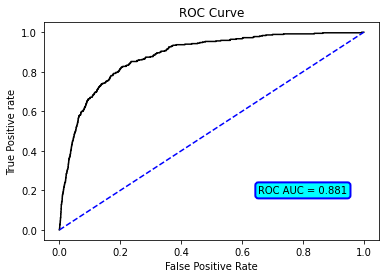

In [183]:
def plot_roc_auc(clf, X, y):

    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)[:,1]
    
    # ROC_AUC
    fpr, tpr, thres = roc_curve(y, y_score)
    auc_score = roc_auc_score(y, y_score)

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y))]
    p_fpr, p_tpr, _ = roc_curve(y, random_probs)

    # plot roc curve
    plt.plot(fpr, tpr, color='black')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    bbox_prop = dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2)
    plt.text(0.8, 0.2, "ROC AUC = {:.3f}".format(auc_score), ha="center", va="center",
                size=10, bbox=bbox_prop)
    plt.show()

plot_roc_auc(lr0, validX, validy)

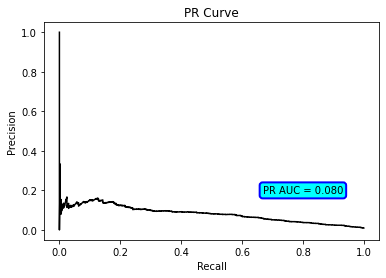

In [184]:
def plot_pr_auc(clf, X, y):

    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)[:,1]
    
    # PR AUC
    pre, rec, thres = precision_recall_curve(y, y_score)
    auc_score = auc(rec, pre)   # precision first arg, recall second! 

    # plot PR curve
    plt.plot(rec, pre, color='black')
    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    bbox_prop = dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2)
    plt.text(0.8, 0.2, "PR AUC = {:.3f}".format(auc_score), ha="center", va="center",
                size=10, bbox=bbox_prop)
    plt.show()

plot_pr_auc(lr0, validX, validy)

# can also use build-in function: plot_precision_recall_curve

### Using resampling technique

In [185]:
from imblearn.over_sampling import SMOTE

In [186]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

LogisticRegression()
AUC for 0.1: 0.8747545750319352
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.25: 0.875487850493673
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.33: 0.8761606430804626
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.5: 0.8767560147643145
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.7: 0.8772198344307764
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for even: 0.8776466727361267
-------------------------------------------------------------------------------------


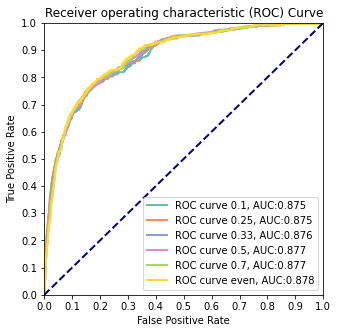

In [187]:
plt.figure(figsize=(5, 5))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=0, k_neighbors=5, n_jobs=-1)
    X_train_resampled, y_train_resampled = smote.fit_resample(trainX, trainy) 
    logreg = LogisticRegression()
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_valid_pred = logreg.predict(validX)

    y_valid_prob = logreg.predict_proba(validX)

    fpr, tpr, thres = roc_curve(validy, y_valid_prob[:,1])
    # or, fpr, tpr, thres = roc_curve(validy, logreg.decision_function(validX))

    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    plt.plot(fpr, tpr, color=colors[n],
             lw=2, label='ROC curve {}, AUC:{}'.format(names[n], round(auc(fpr, tpr),3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.yticks([i/10.0 for i in range(11)])
plt.xticks([i/10.0 for i in range(11)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression()
AUC for 0.1: 0.1038765689013784
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.25: 0.09738597644308052
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.33: 0.09400959550679734
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.5: 0.08937712444637749
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for 0.7: 0.08620386992092273
-------------------------------------------------------------------------------------
LogisticRegression()
AUC for even: 0.08316075099385366
-------------------------------------------------------------------------------------


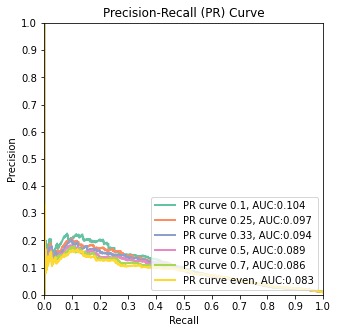

In [188]:
plt.figure(figsize=(5, 5))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=0, k_neighbors=5, n_jobs=-1)
    X_train_resampled, y_train_resampled = smote.fit_resample(trainX, trainy) 
    logreg = LogisticRegression()
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)
    
    # Predict
    y_valid_pred = logreg.predict(validX)

    y_valid_prob = logreg.predict_proba(validX)

    pre, rec, thres = precision_recall_curve(validy, y_valid_prob[:,1])
    
    print('AUC for {}: {}'.format(names[n], auc(rec, pre)))
    print('-------------------------------------------------------------------------------------')
    plt.plot(rec, pre, color=colors[n],
             lw=2, label='PR curve {}, AUC:{}'.format(names[n], round(auc(rec, pre),3)))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.yticks([i/10.0 for i in range(11)])
plt.xticks([i/10.0 for i in range(11)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower right')
plt.show()

### Grid search on class_weight and other hyperparameters

Scorer is ROC AUC

In [189]:
t0 = time.time()

# define model
lg2 = LogisticRegression()

# define hyperparameters
# note: {0:1.0,1:1.0} does not yield the same results as 'balanced'
w = [{0:100,1:1.0}, {0:10,1:1.0}, {0:1.0,1:1.0},{0:1.0,1:10}, {0:1.0,1:30}, {0:1.0,1:100}]
crange = [0.1, 0.3, 1, 3, 10]

hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }


# define evaluation procedure
def roc_auc_scorer(estimator, X, y):
    y_score = estimator.predict_proba(X)[:,1]
    fpr, tpr, thres = roc_curve(y, y_score)
    return auc(fpr, tpr)
    # maybe can just use scoring='auc_roc'

grid = GridSearchCV(lg2,hyperparam_grid,scoring=roc_auc_scorer, cv=3, n_jobs=-1)    
    
grid.fit(trainX,trainy)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

t1 = time.time()
total = t1-t0
print("mins:",round(total/60, 5))

# or you can just start a line with ##time

Best score: 0.8775044827701017 with param: {'C': 0.1, 'class_weight': {0: 1.0, 1: 100}, 'fit_intercept': False, 'penalty': 'l2'}
mins: 0.73013


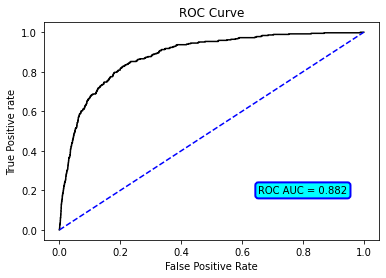

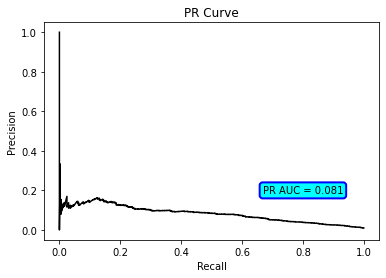

In [190]:
# define model
lg2 = LogisticRegression(class_weight={0: 1, 1: 100},C=0.1, fit_intercept=False)

# fit it
lg2.fit(trainX, trainy)

# test and performance
plot_roc_auc(lg2, validX, validy)
plot_pr_auc(lg2, validX, validy)

#y_pred = lg3.predict(validX)
#print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
#print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
#print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
#print(f'Recall score: {recall_score(y_test,y_pred)}')

Scorer is PR AUC

In [ ]:
t0 = time.time()

# define model
lg3 = LogisticRegression()

# define hyperparameters
# note: {0:1.0,1:1.0} does not yield the same results as 'balanced'
w = [{0:100,1:1.0}, {0:10,1:1.0}, {0:1.0,1:1.0},{0:1.0,1:10}, {0:1.0,1:30}, {0:1.0,1:100}]
crange = [0.1, 0.3, 1, 3, 10]

hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }


# define evaluation procedure
def pr_auc_scorer(estimator, X, y):
    y_score = estimator.predict_proba(X)[:,1]
    pre, rec, thres = precision_recall_curve(y, y_score)
    return auc(rec, pre)
    # maybe can use average_precision_score, but note this is different from pr_auc_score

grid = GridSearchCV(lg3,hyperparam_grid,scoring=pr_auc_scorer, cv=3, n_jobs=-1)    
    
grid.fit(trainX,trainy)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

t1 = time.time()
total = t1-t0
print("mins:",round(total/60, 5))

In [ ]:
# define model
lg3 = LogisticRegression(class_weight={0: 100, 1: 1.0},C=3, fit_intercept=False)

# fit it
lg3.fit(trainX, trainy)

# test and performance
plot_roc_auc(lg3, validX, validy)
plot_pr_auc(lg3, validX, validy)

#y_pred = lg3.predict(validX)
#print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
#print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
#print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
#print(f'Recall score: {recall_score(y_test,y_pred)}')

### TBD: Choose threshold

In [ ]:
# default is 0.5
# need to find the optimal threshold

## TBD: XGBoost model

# Feature interpretation

In [ ]:
# use lg3 as the optimized model

importance = pd.DataFrame()

importance['feature'] = X_train.iloc[:,1:].columns
importance['coefficient'] = lg3.coef_[0]
importance.sort_values('coefficient', axis=0, ascending=False, inplace=True)

In [ ]:
# Visualize the feature importance
plt.figure(figsize=(20,5))
plt.bar(x=importance['feature'], height=importance['coefficient'])
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)
plt.show()

In [ ]:
# Select top features

top = 10

importance['abs_coefficient'] = np.abs(importance['coefficient'])
importance.sort_values('abs_coefficient', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(10,5))
plt.bar(x=importance['feature'][:top], height=importance['coefficient'][:top])
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)
plt.show()

In [ ]:
# Look at the positive features

top = 10

importance.sort_values('coefficient', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(10,5))
plt.bar(x=importance['feature'][:top], height=importance['coefficient'][:top])
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)
plt.show()

**Next steps and questions:**
1. Remove associated categorical features so that we have more confidence on identifying important features. We look for advice on how to detect and remove associated features (categorical & categorical, categorical & numerical).
2. Choose the model based on ROC AUC (or PR AUC?), and determine proper threshold for classifying labels. Will refer to an aritical "Threshold-Moving for Imbalanced Classification".
3. Complete tree-based models. We look for advice on how to interpret feature importance.
4. If time allows, will look into partial dependency plot
5. If time allows, will look into segmentation of customers

**1. Why this project is important? What problem are you trying to solve?**

Marketing deparments commonly face budget constrainsts and need insights to design effective marketing campaigns, which may be defined as higher conversion rate, click-through rick, product purchase rate, etc. This project aims to address this need by developing an enhanced marketing analytics platform. In addition to providing conventional data analysis and visualization functions, this platform leverages machine learning techniques to identify patterns that cannot be uncovered otherwise. 

The specific modeling problem we are trying to solve is predicting the coupon redemption status based on campaign design, coupon design, and customer behavior. A high performance model will allow us to identify important features, from which we can gain insights on what factors are key to marketing success to inform further campaign efforts. 

**2. How do you measure the model performance (metrics)? What is the benchmark?**

ROC AUC and PR AUC. 

A model without any skill would have a ROC AUC score of 0.5 and a PR AUC score equal to the base rate (0.93%).

**3. How is your model? Have achieved your goal? How to evaluate the business value of your model?**

My model has a ROC AUC score of 0.881 and a PR AUC score of 0.133. The model performance is decent.

Here is a hypothetical yet realistic example of business value estimation. Say we have 10,000 customers, and it takes 50 cents to promote products to each customer. This requires 5,000 USD for each marketing campaign. If campaigns are done semi-monthy (very conservative), then the total cost sums up to 120,000 USD per year. My model can help the users understand the purchase behaviors of their customers, so that they can better target the customers when promoting specific products (**How to realize this? Do we need to do clustering based on demographics and transaction data?**). This can drastically reduce cost without taking a major hit on conversion. 

Right now the dataset used to build the model has a very low conversion rate (<1%). My model can identify the factors that increase/decrease the conversion rate. By designing campaigns with features favoring higher conversion rate, the sales can go up, resulting in more profits.

**4. Any insights have you gotten from your model? Any actionable suggestions can you provide to your business partner?**

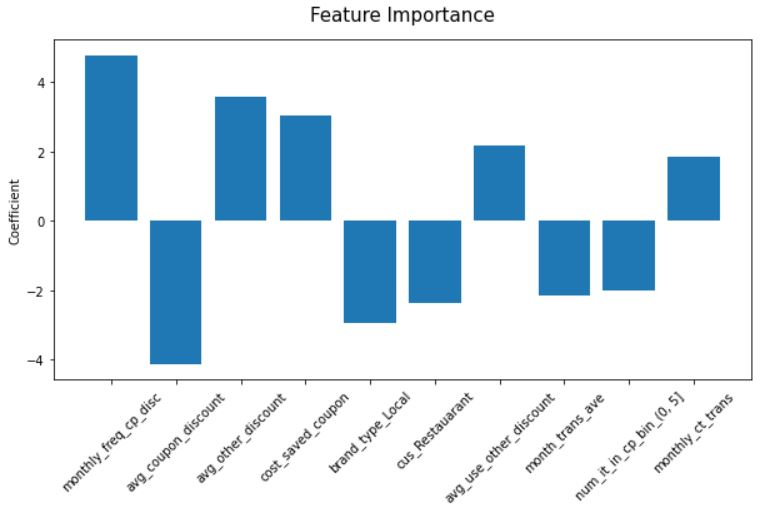

Preliminary results:
1. Customers exhibiting certain purchase behavior (e.g., high monthly frequency of using coupon discount, tendency to purchase larger quantity of goods, and tendency to use other discount) are more likely going to utilize promotions.
2. Restaurants promotions are not effective through coupon campaigns.
3. Coupons that only contain local goods are less likely to be used. It's possible that local goods are generally cheaper than established brands, so the coupons promoting established brands get deemed more often.
4. If a coupon only contains a few items, it is less likely to be utilized.

**5. What is the most challenging part in the project? How did you solve it? How will you futher improve your model if you get more resources and time.**

Two challenges are worth highlighting. One is feature engineering from a large transaction dataset. The other is that the data is extremely imbalanced.

To address the first challenge, I work closely with team members (DAs and DSs) to create a large number of features for evaluation and downselection. This process is iterative and was done effectively by weekly meetings and instant messages. For the second challenge, I applied several techniques known to handle imbalanced data, such as resampling the data, modifying the objective function, and investigating different metrics. 


To further improve the model, I would like to work with the business colleagues and data engineers to see if we can get more customer related features. That should help us further understand our customers, making more complete customer profile. I also hope to test some other techniques to handle imbalanced data, such as using bagging algorithms. 

**Test dataset prediction and submission**

In [ ]:
# Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.  

y_test_score = lg2.predict_proba(X_test_scaled)[:,1]

test['redemption_status'] = y_test_score # probability
prediction_submission = test[['id','redemption_status']]

#prediction_submission.to_csv(r'.\prediction_submission.csv')